# NVDA Stock Forecast

The aim of this notebook is to find the best stock listed in the S&P 500 index to invest in and then predict the said stock's future price with determined models.

S&P 500 Index data is from 2014-07-21 until 2024-07-19
S&P 500 Stocks data is from 2010-01-04 until 2024-07-19

In [1]:
# Import Library

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

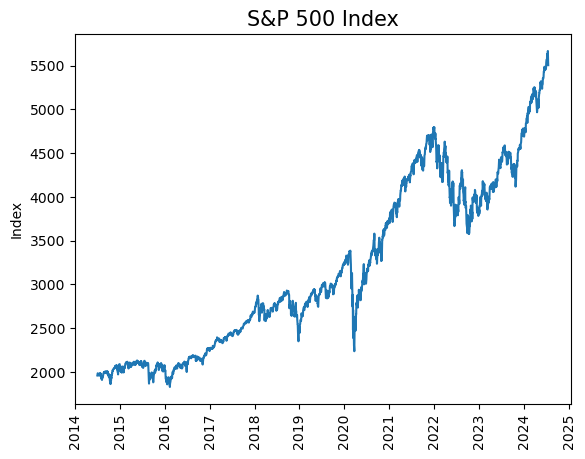

In [2]:
# S&P 500 Index graph

import matplotlib.dates as mdates

dfindex=pd.read_csv('sp500_index.csv')
dfindex['Date']=pd.to_datetime(dfindex['Date'])
fig, ax = plt.subplots()
ax.plot(dfindex['Date'], dfindex['S&P500'])
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=90)
plt.ylabel('Index')
plt.title('S&P 500 Index', size = 15)
plt.show()

The S&P 500 index has shown steady growth over the years, except for several declines here and there. The worst decline happened in 2020 because of the COVID-19 pandemic, and in 2022 because of a combination of financial stability from the COVID-19 pandemic and the Russian invasion of Ukraine.

In [3]:
df1=pd.read_csv('sp500_companies.csv')
dfcomp=df1[df1['Exchange']=='NMS'] # we will use the NMS exchange
dfcomp.drop(4, inplace=True) # drop GOOGL to avoid confusion
dfcomp

,Exchange,Symbol,Shortname,Longname,Sector,Industry,Currentprice,Marketcap,Ebitda,Revenuegrowth,City,State,Country,Fulltimeemployees,Longbusinesssummary,Weight
0,NMS,AAPL,Apple Inc.,Apple Inc.,Technology,Consumer Electronics,224.31,3439591948288,1.296290e+11,-0.043,Cupertino,CA,United States,150000.0,"Apple Inc. designs, manufactures, and markets ...",0.066545
1,NMS,MSFT,Microsoft Corporation,Microsoft Corporation,Technology,Software - Infrastructure,437.11,3272965881856,1.259820e+11,0.170,Redmond,WA,United States,221000.0,Microsoft Corporation develops and supports so...,0.063321
2,NMS,NVDA,NVIDIA Corporation,NVIDIA Corporation,Technology,Semiconductors,117.93,2978616967168,4.927500e+10,2.621,Santa Clara,CA,United States,29600.0,NVIDIA Corporation provides graphics and compu...,0.057626
3,NMS,GOOG,Alphabet Inc.,Alphabet Inc.,Communication Services,Internet Content & Information,179.39,2206586634240,1.097230e+11,0.154,Mountain View,CA,United States,180895.0,Alphabet Inc. offers various products and plat...,0.042690
5,NMS,AMZN,"Amazon.com, Inc.","Amazon.com, Inc.",Consumer Cyclical,Internet Retail,183.13,1912225267712,9.660900e+10,0.125,Seattle,WA,United States,1525000.0,"Amazon.com, Inc. engages in the retail sale of...",0.036995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,NMS,HAS,"Hasbro, Inc.","Hasbro, Inc.",Consumer Cyclical,Leisure,59.00,8213744128,6.732000e+08,-0.243,Pawtucket,RI,United States,5502.0,"Hasbro, Inc., together with its subsidiaries, ...",0.000159
496,NMS,PARA,Paramount Global,Paramount Global,Communication Services,Entertainment,11.52,8100507648,2.715000e+09,0.058,New York,NY,United States,21900.0,"Paramount Global operates as a media, streamin...",0.000157
497,NMS,CZR,"Caesars Entertainment, Inc.","Caesars Entertainment, Inc.",Consumer Cyclical,Resorts & Casinos,36.86,7963713536,3.714000e+09,-0.031,Reno,NV,United States,51000.0,"Caesars Entertainment, Inc. operates as a gami...",0.000154
499,NMS,ETSY,"Etsy, Inc.","Etsy, Inc.",Consumer Cyclical,Internet Retail,62.76,7338715136,4.262970e+08,0.008,Brooklyn,NY,United States,2420.0,"Etsy, Inc., together with its subsidiaries, op...",0.000142


I will read about the companies listed in NMS only. I decided to drop GOOGL too to avoid confusion since we have GOOG already.

## Exploratory Data Analysis by Sector

Text(0.5, 1.0, 'Total Companies by Sector')

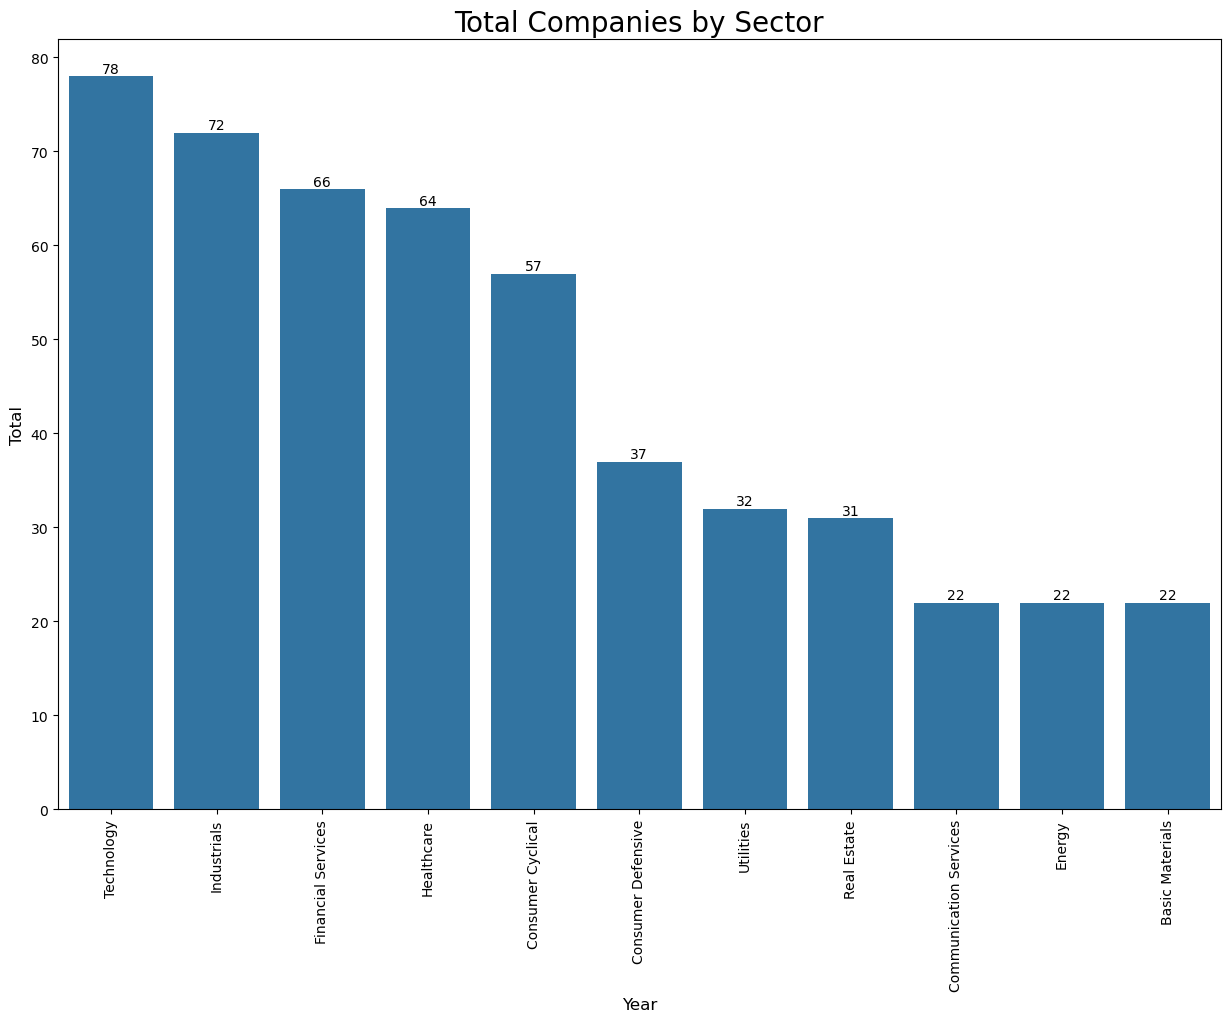

In [4]:
# Company Count

plt.figure(figsize=(15,10))
sec_count=sns.countplot(x='Sector',data=df1, order=df1['Sector'].value_counts().sort_values(ascending=False).index)
sec_count.bar_label(sec_count.containers[0], label_type='edge')
plt.xticks(rotation=90)
plt.xlabel('Year', size = 12)
plt.ylabel('Total', size = 12)
plt.title ('Total Companies by Sector', size = 20)

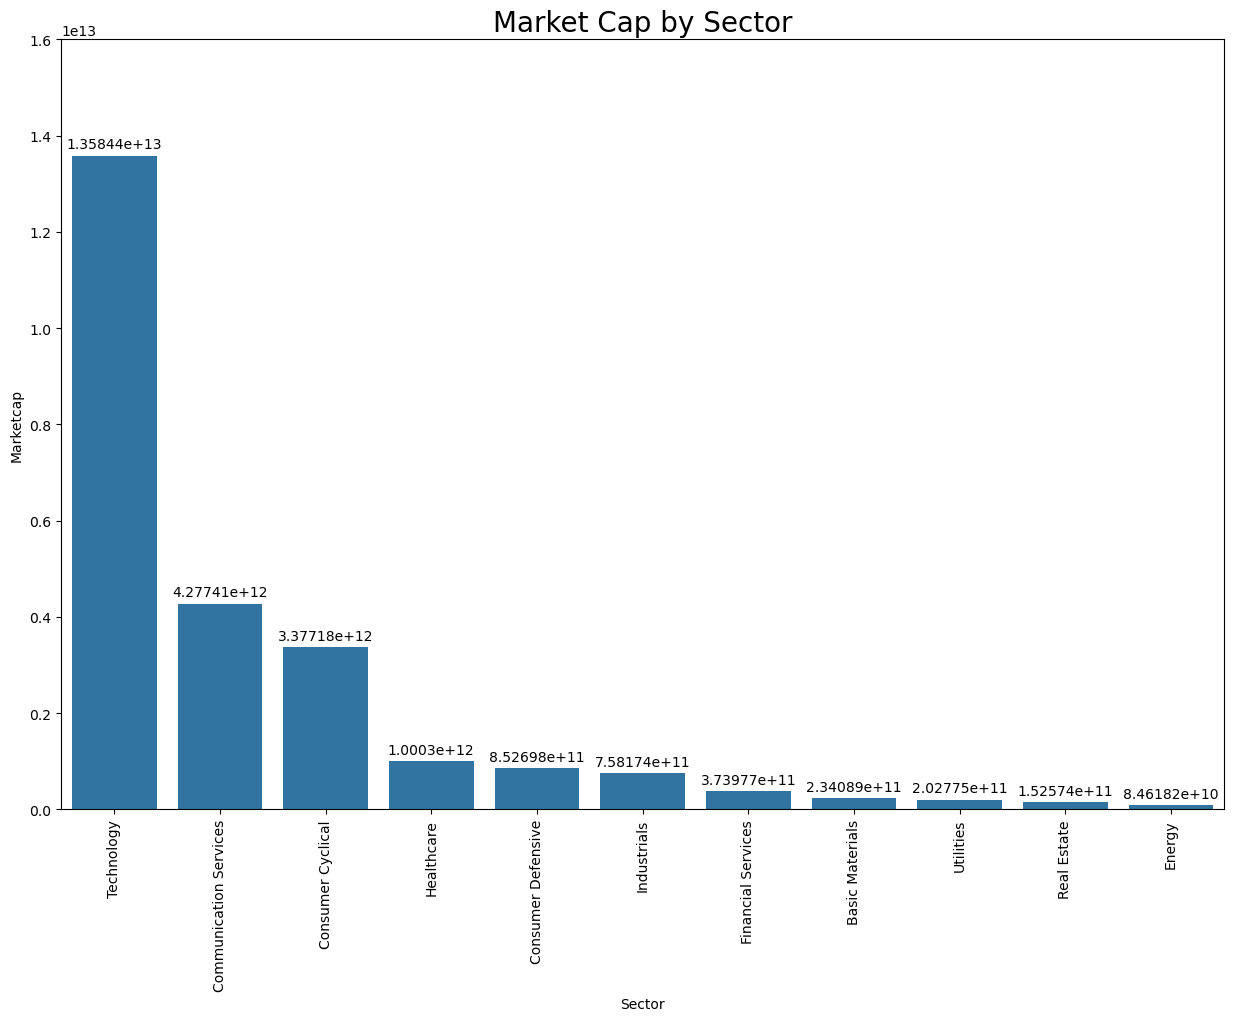

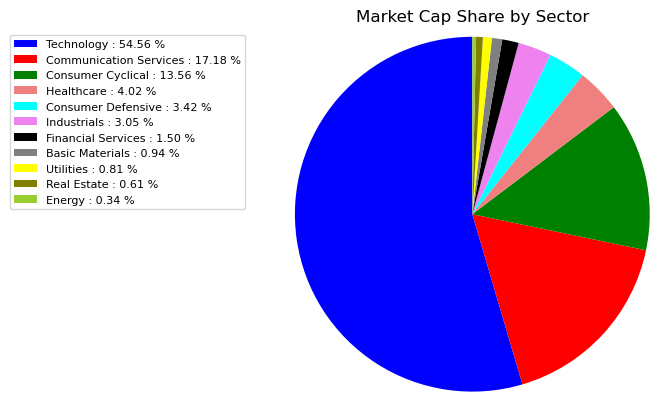

In [5]:
# Marketcap

secm=dfcomp.groupby(by=['Sector'])['Marketcap'].sum().reset_index().sort_values(by='Marketcap',ascending=False)
percent = 100.*secm['Marketcap']/secm['Marketcap'].sum()

plt.figure(figsize=(15,10))
sec_m=sns.barplot(x='Sector',y='Marketcap',ci=None, data=secm)
sec_m.bar_label(sec_m.containers[0], label_type='edge', rotation=0, padding=3)
plt.xticks(rotation=90)
plt.title('Market Cap by Sector', size = 20)
plt.yticks(range(0,int(18e12),int(2e12)))
plt.show()

colors={'Technology':'blue',
        'Communication Services':'red',
        'Consumer Cyclical':'green',
        'Healthcare':'lightcoral',
        'Consumer Defensive':'cyan',
        'Industrials':'violet',
        'Financial Services':'black',
        'Basic Materials':'grey',
        'Utilities':'yellow',
        'Real Estate':'olive',
        'Energy':'yellowgreen'}
patches, texts = plt.pie(secm['Marketcap'], colors=[colors[p] for p in secm['Sector']], startangle=90, radius=1.2)
labels = ['{0} : {1:1.2f} %'.format(i,j) for i,j in zip(secm['Sector'], percent)]
sort_legend = True 
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, secm['Marketcap']),
                                          key=lambda x:x[2],
                                          reverse=True))
plt.legend(patches, labels, loc='best', bbox_to_anchor=(-0.1, 1.),
           fontsize=8)
plt.title('Market Cap Share by Sector')
plt.savefig('piechart.png', bbox_inches='tight')

# Reference https://stackoverflow.com/questions/23577505/how-to-avoid-overlapping-of-labels-autopct-in-a-pie-chart

The S&P 500 index market cap is dominated by Technology sector, which accounts for 54.56% of all listed companies. The other sectors with a considerably large market cap are Communication Services with 17.18% share and Consumer Cyclical with 13.56% share. These three sectors account for more than 85% of the of the market cap of S&P 500-listed companies.

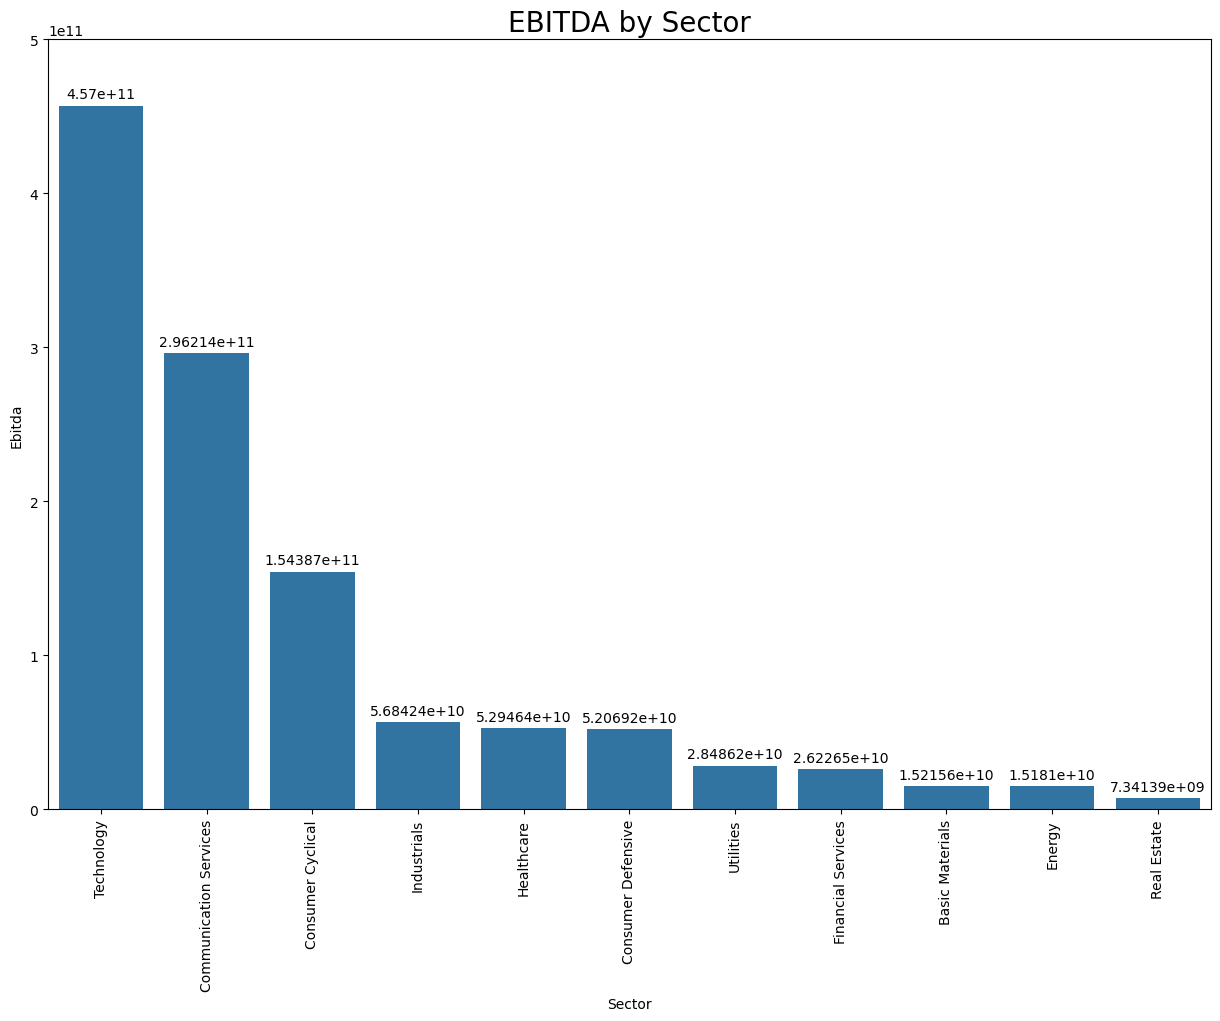

In [6]:
# Ebitda

sece=dfcomp.groupby(by=['Sector'])['Ebitda'].sum().reset_index()
sece=sece.sort_values(by='Ebitda', ascending=False)
sece.reset_index(drop=True)
plt.figure(figsize=(15,10))
sec_e=sns.barplot(x='Sector',y='Ebitda',ci=None, data=sece)
sec_e.bar_label(sec_e.containers[0], label_type='edge', rotation=0, padding=3)
plt.xticks(rotation=90)
plt.title('EBITDA by Sector', size = 20)
plt.yticks(range(0,int(6e11),int(1e11)))
plt.show()

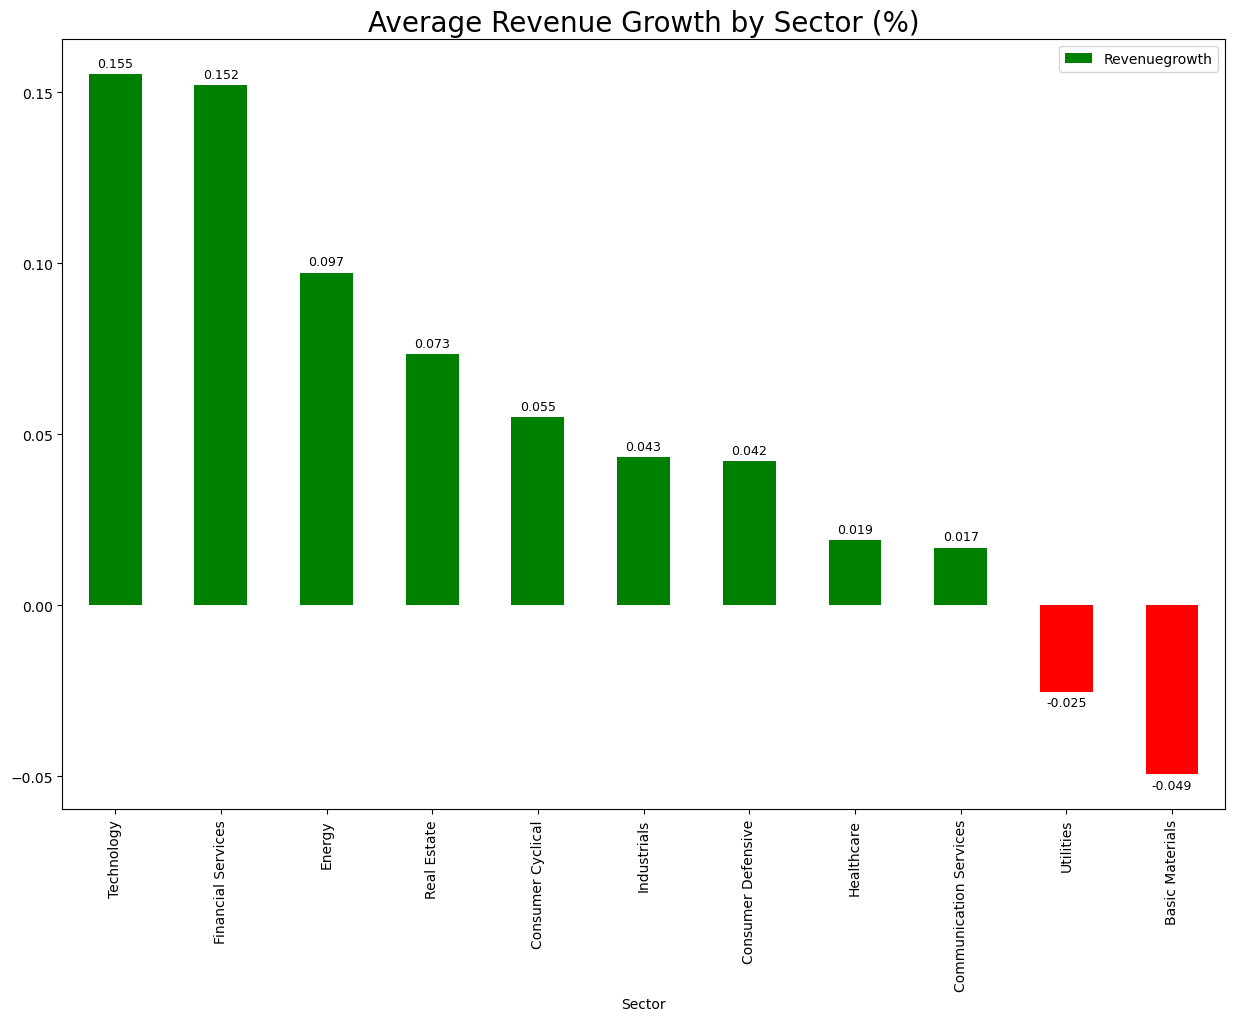

In [7]:
# Revenue Growth

secr=dfcomp.groupby(by=['Sector'])['Revenuegrowth'].mean().reset_index()
secr=secr.sort_values(by='Revenuegrowth', ascending=False)
secr.reset_index(drop=True)
clr = []
for val in secr['Revenuegrowth']:
    if val < 0:
        clr.append('Red')
    else:
        clr.append('Green')
sec_r=secr.plot(x='Sector',y='Revenuegrowth',kind='bar', color=clr, figsize=(15, 10))
sec_r.bar_label(sec_r.containers[0], label_type='edge', rotation=0, padding=3, fontsize=9,fmt='%.3f')
plt.xticks(rotation=90)
plt.title('Average Revenue Growth by Sector (%)', size = 20)
plt.show()

Most of the sectors recorded modest revenue growth, except Utilities and Basic Materials, which recorded a slight loss. 

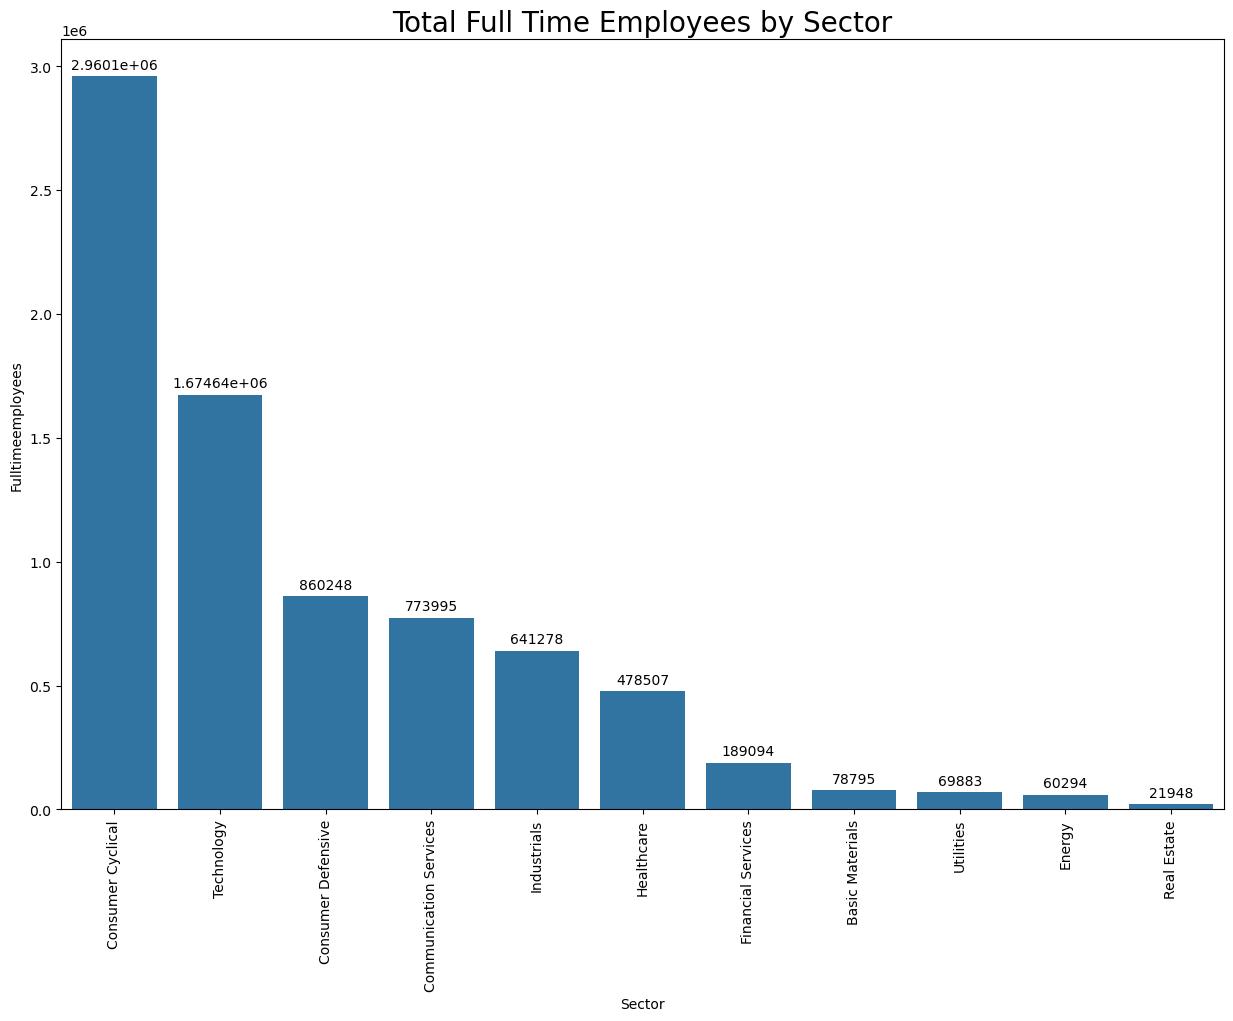

In [8]:
# Full-time Employees

secf=dfcomp.groupby(by=['Sector'])['Fulltimeemployees'].sum().reset_index()
secf=secf.sort_values(by='Fulltimeemployees', ascending=False)
secf.reset_index(drop=True)
plt.figure(figsize=(15,10))
sec_f=sns.barplot(x='Sector',y='Fulltimeemployees',ci=None, data=secf)
sec_f.bar_label(sec_f.containers[0], label_type='edge', rotation=0, padding=3)
plt.xticks(rotation=90)
plt.title('Total Full Time Employees by Sector', size = 20)
plt.yticks(range(0,int(35e5),int(5e5)))
plt.show()

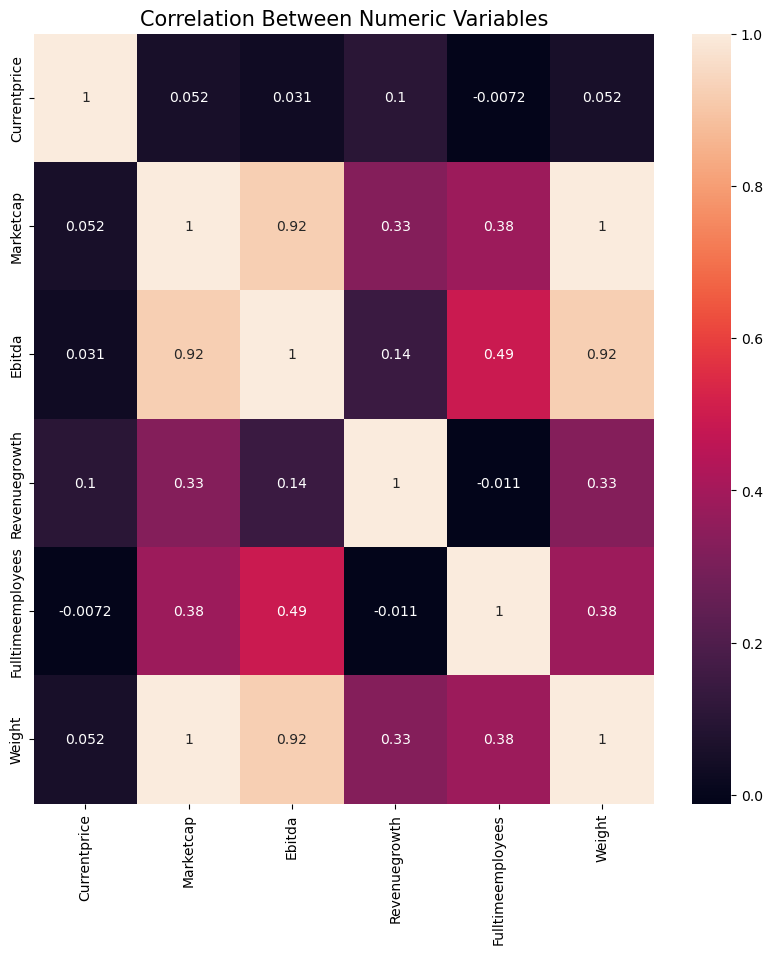

In [9]:
# Correlation between numeric variables

plt.figure(figsize=(10,10))
sns.heatmap(dfcomp.corr('pearson'),annot=True)
plt.title('Correlation Between Numeric Variables', size = 15)
plt.show()

Let's just focus on the current price variable. Most of the other variables have a weak correlation with the current price. The current price has the highest correlation with Revenue Growth. It seems fundamental variables such as the company's potential are more considered.

# Stocks Selection

So, what's the best stock to invest in? Let's choose the safest stocks for now. Most risk-averse people would just straight-up pick blue-chip stocks to invest in. Investopedia said that a blue-chip stock refers to the shares of an established, profitable, and well-recognized corporation. Blue chips are characterized by a large market capitalization, a listing on a major stock exchange, and a history of reliable growth and dividend payments.

Let's sort the stock dataframe by weight, and then choose the top 10 with the largest weight.

In [10]:
dfcomp.sort_values(by='Weight', ascending=False).head(10)

,Exchange,Symbol,Shortname,Longname,Sector,Industry,Currentprice,Marketcap,Ebitda,Revenuegrowth,City,State,Country,Fulltimeemployees,Longbusinesssummary,Weight
0,NMS,AAPL,Apple Inc.,Apple Inc.,Technology,Consumer Electronics,224.31,3439591948288,1.296290e+11,-0.043,Cupertino,CA,United States,150000.0,"Apple Inc. designs, manufactures, and markets ...",0.066545
1,NMS,MSFT,Microsoft Corporation,Microsoft Corporation,Technology,Software - Infrastructure,437.11,3272965881856,1.259820e+11,0.170,Redmond,WA,United States,221000.0,Microsoft Corporation develops and supports so...,0.063321
2,NMS,NVDA,NVIDIA Corporation,NVIDIA Corporation,Technology,Semiconductors,117.93,2978616967168,4.927500e+10,2.621,Santa Clara,CA,United States,29600.0,NVIDIA Corporation provides graphics and compu...,0.057626
3,NMS,GOOG,Alphabet Inc.,Alphabet Inc.,Communication Services,Internet Content & Information,179.39,2206586634240,1.097230e+11,0.154,Mountain View,CA,United States,180895.0,Alphabet Inc. offers various products and plat...,0.042690
5,NMS,AMZN,"Amazon.com, Inc.","Amazon.com, Inc.",Consumer Cyclical,Internet Retail,183.13,1912225267712,9.660900e+10,0.125,Seattle,WA,United States,1525000.0,"Amazon.com, Inc. engages in the retail sale of...",0.036995
6,NMS,META,"Meta Platforms, Inc.","Meta Platforms, Inc.",Communication Services,Internet Content & Information,476.79,1209392168960,6.844700e+10,0.273,Menlo Park,CA,United States,69329.0,"Meta Platforms, Inc. engages in the developmen...",0.023398
8,NMS,TSLA,"Tesla, Inc.","Tesla, Inc.",Consumer Cyclical,Auto Manufacturers,239.20,794842431488,1.226500e+10,-0.087,Austin,TX,United States,140473.0,"Tesla, Inc. designs, develops, manufactures, l...",0.015378
10,NMS,AVGO,Broadcom Inc.,Broadcom Inc.,Technology,Semiconductors,157.35,732445343744,2.129100e+10,0.164,Palo Alto,CA,United States,20000.0,"Broadcom Inc. designs, develops, and supplies ...",0.014170
20,NMS,COST,Costco Wholesale Corporation,Costco Wholesale Corporation,Consumer Defensive,Discount Stores,838.13,371572375552,1.124300e+10,0.091,Issaquah,WA,United States,316000.0,"Costco Wholesale Corporation, together with it...",0.007189
27,NMS,NFLX,"Netflix, Inc.","Netflix, Inc.",Communication Services,Entertainment,633.34,277086896128,8.226066e+09,0.148,Los Gatos,CA,United States,13000.0,"Netflix, Inc. provides entertainment services....",0.005361


In [11]:
c=pd.read_csv('sp500_stocks.csv')
dfstock=c[c['Symbol'].isin(['MSFT','AAPL','NVDA','GOOG','AMZN','META','AVGO','TSLA','COST','NFLX'])]
dfstock.reset_index(drop=True, inplace=True)
dfstocks=dfstock[['Date','Symbol','Adj Close']]
dfstocks

,Date,Symbol,Adj Close
0,2010-01-04,GOOG,NaN
1,2010-01-05,GOOG,NaN
2,2010-01-06,GOOG,NaN
3,2010-01-07,GOOG,NaN
4,2010-01-08,GOOG,NaN
...,...,...,...
36595,2024-07-15,TSLA,252.639999
36596,2024-07-16,TSLA,256.559998
36597,2024-07-17,TSLA,248.500000
36598,2024-07-18,TSLA,249.229996


In [12]:
dfstocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36600 entries, 0 to 36599
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       36600 non-null  object 
 1   Symbol     36600 non-null  object 
 2   Adj Close  34815 non-null  float64
dtypes: float64(1), object(2)
memory usage: 857.9+ KB


In [13]:
# Drop missing values

dfstocks.dropna(inplace=True)

In [14]:
# Change date datatype to datetime

dfstocks['Date']=pd.to_datetime(dfstocks['Date'])
dfstocks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34815 entries, 1064 to 36599
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       34815 non-null  datetime64[ns]
 1   Symbol     34815 non-null  object        
 2   Adj Close  34815 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 1.1+ MB


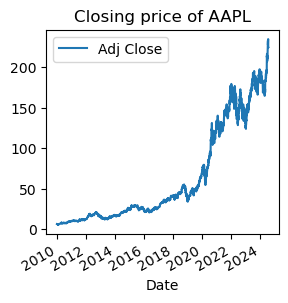

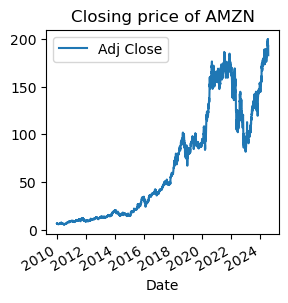

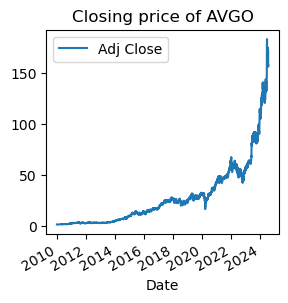

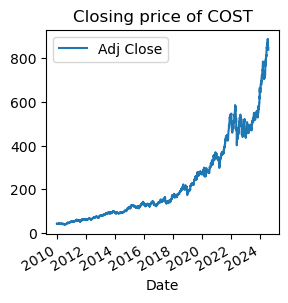

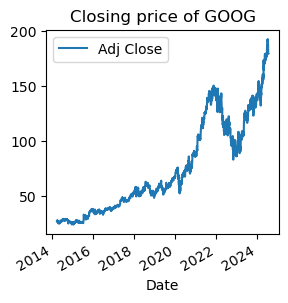

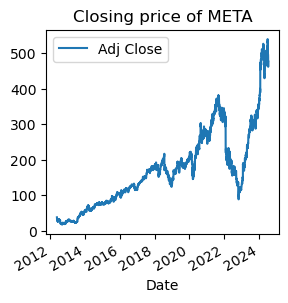

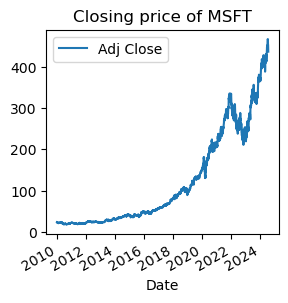

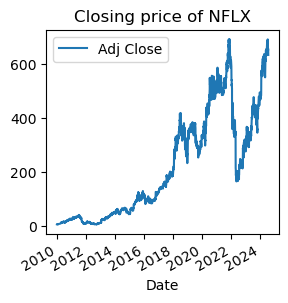

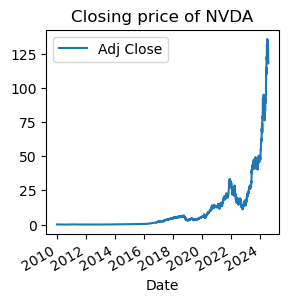

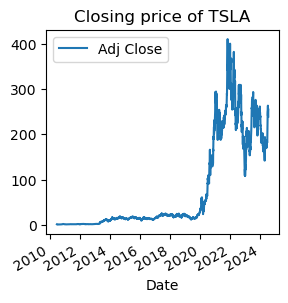

In [15]:
# Price trends for each stocks

for Stock, df in dfstocks.groupby('Symbol'):
    df.plot('Date', figsize=(3,3))
    plt.title(f'Closing price of {Stock}')

The graphs show that the chosen stocks exhibit very good growth and mostly correspond with S&P 500 index growth, which makes sense since these are stocks with the largest weight. Some stocks look more resilient than others, even during stock market declines, such as AVGO, COST, and NVDA.

In [16]:
# Separating stocks

def separate_stocks(stck):
    symbol = dfstocks[dfstocks['Symbol']==stck]
    symbol.rename(columns={'Date': 'ds','Adj Close': 'y'}, inplace=True)
    symbol.drop(['Symbol'],axis=1, inplace=True)
    symbol.reset_index(drop=True,inplace=True)
    return symbol

MSFT=separate_stocks('MSFT')
AAPL=separate_stocks('AAPL')
NVDA=separate_stocks('NVDA')
GOOG=separate_stocks('GOOG')
AMZN=separate_stocks('AMZN')
META=separate_stocks('META')
AVGO=separate_stocks('AVGO')
TSLA=separate_stocks('TSLA')
COST=separate_stocks('COST')
NFLX=separate_stocks('NFLX')

In [17]:
# Total gain from 2010 until now

def total_gain(S):
    gain = (S.iloc[-1]['y'] - S.iloc[0]['y'])/S.iloc[0]['y']*100
    return gain

MSFT_gain=total_gain(MSFT)
AAPL_gain=total_gain(AAPL)
NVDA_gain=total_gain(NVDA)
GOOG_gain=total_gain(GOOG)
AMZN_gain=total_gain(AMZN)
META_gain=total_gain(META)
AVGO_gain=total_gain(AVGO)
TSLA_gain=total_gain(TSLA)
COST_gain=total_gain(COST)
NFLX_gain=total_gain(NFLX)

gain_col = ['Stocks', 'Gain/Loss (%)','Variance']
gain_data=[('MSFT', MSFT_gain, np.var(MSFT['y'])), ('AAPL', AAPL_gain, np.var(AAPL['y'])), 
           ('NVDA', NVDA_gain, np.var(NVDA['y'])), ('GOOG', GOOG_gain, np.var(GOOG['y'])), 
           ('AMZN', AMZN_gain, np.var(AMZN['y'])), ('META', META_gain, np.var(META['y'])), 
           ('AVGO', AVGO_gain, np.var(AVGO['y'])), ('TSLA', TSLA_gain, np.var(TSLA['y'])), 
           ('COST', COST_gain, np.var(COST['y'])), ('NFLX', NFLX_gain, np.var(NFLX['y']))]
df_gain = pd.DataFrame(gain_data, columns=gain_col)
df_gain = df_gain.sort_values(['Gain/Loss (%)','Variance'],ascending=[False,True]).reset_index(drop=True)
df_gain

,Stocks,Gain/Loss (%),Variance
0,NVDA,60299.210017,391.482820
1,TSLA,14918.833153,10467.614362
2,AVGO,8243.054242,952.905246
3,NFLX,8189.791072,37283.304816
4,AAPL,3371.229425,3615.953060
5,AMZN,2635.324872,3363.337255
6,COST,1872.133794,35079.897393
7,MSFT,1768.837767,13515.952900
8,META,1149.724683,12161.820682
9,GOOG,544.942243,1734.448822


Variance is added as we are considering which stocks are safer than the others, other than good growth. We see that NVDA is by far the best stock to invest in since it has very high growth while also having less variance than the others.

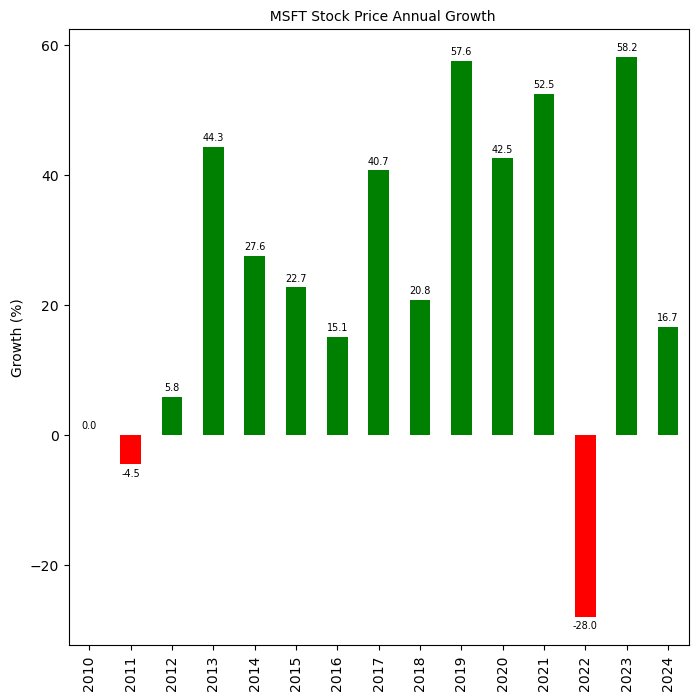

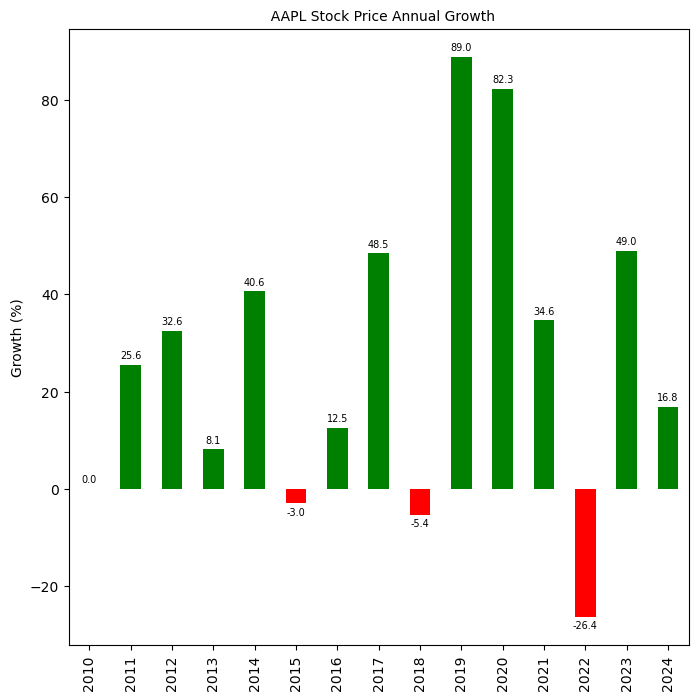

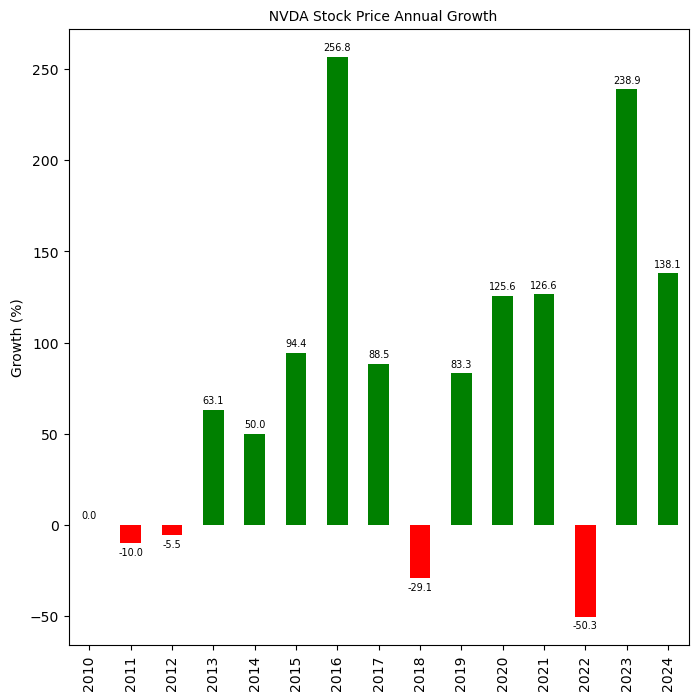

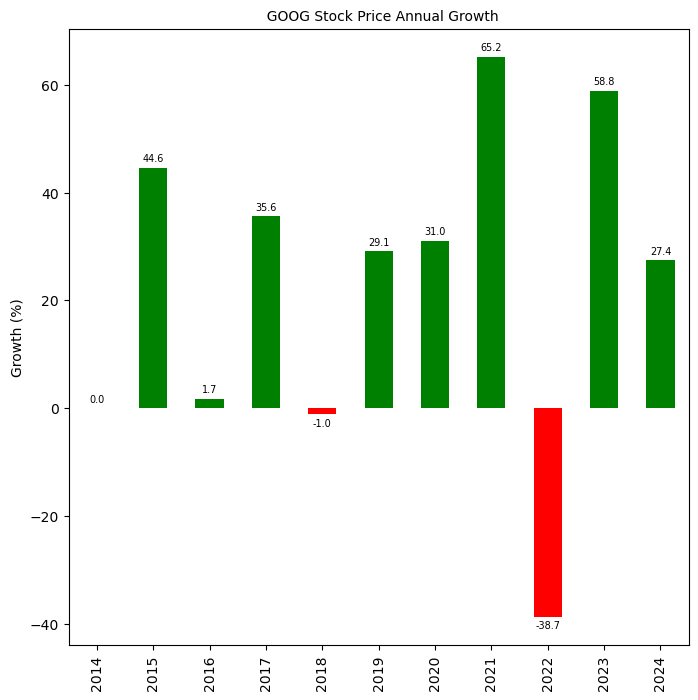

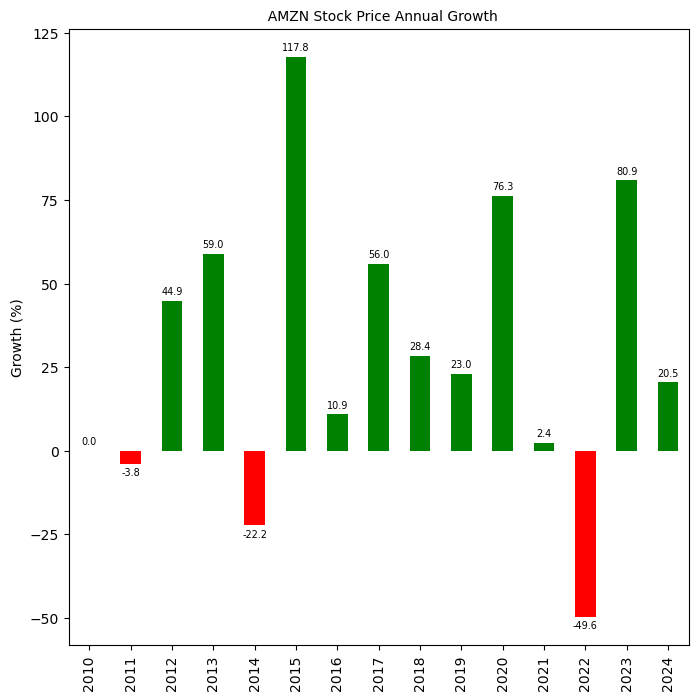

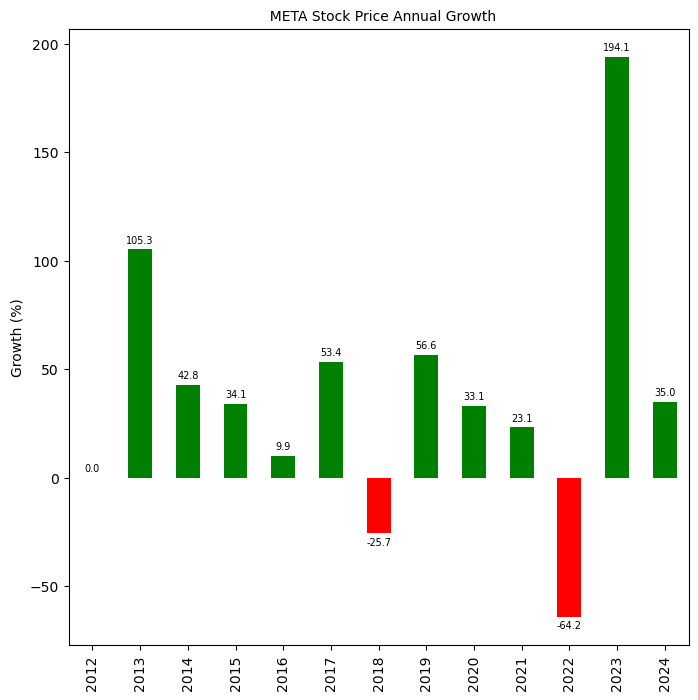

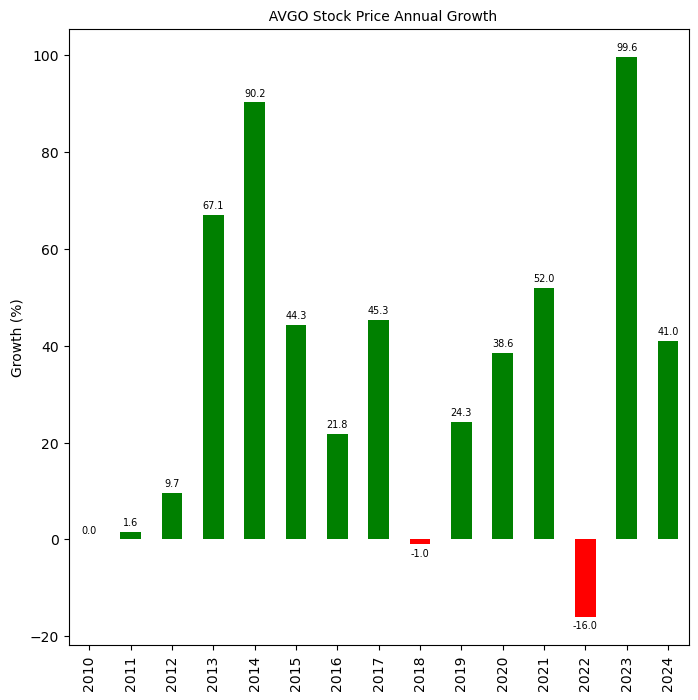

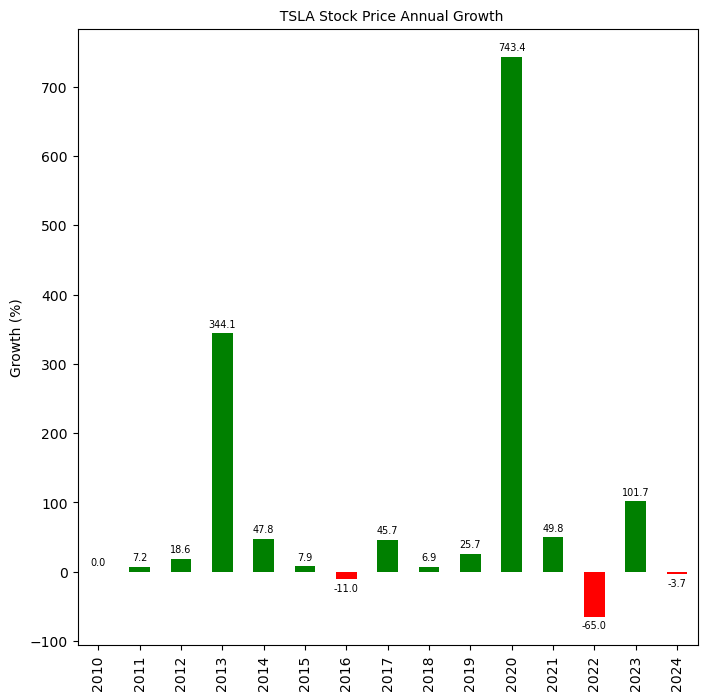

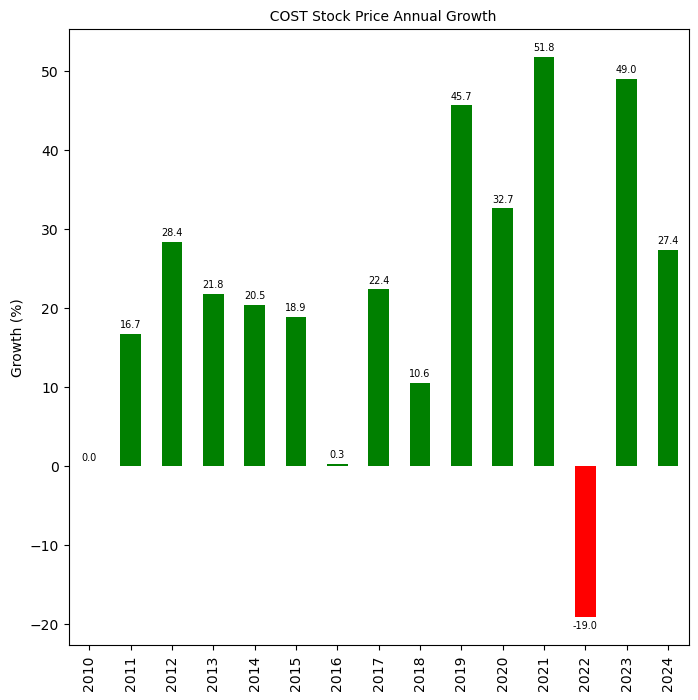

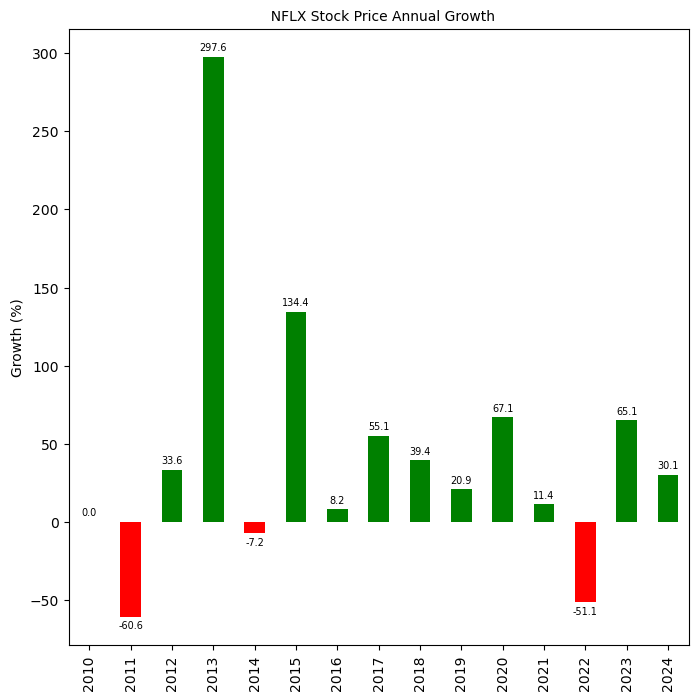

In [18]:
# Create annual price change plots

ann_MSFT=MSFT.resample('AS', on='ds')['y'].agg(['last']).pct_change().mul(100).reset_index()
ann_AAPL=AAPL.resample('AS', on='ds')['y'].agg(['last']).pct_change().mul(100).reset_index()
ann_NVDA=NVDA.resample('AS', on='ds')['y'].agg(['last']).pct_change().mul(100).reset_index()
ann_GOOG=GOOG.resample('AS', on='ds')['y'].agg(['last']).pct_change().mul(100).reset_index()
ann_AMZN=AMZN.resample('AS', on='ds')['y'].agg(['last']).pct_change().mul(100).reset_index()
ann_META=META.resample('AS', on='ds')['y'].agg(['last']).pct_change().mul(100).reset_index()
ann_AVGO=AVGO.resample('AS', on='ds')['y'].agg(['last']).pct_change().mul(100).reset_index()
ann_TSLA=TSLA.resample('AS', on='ds')['y'].agg(['last']).pct_change().mul(100).reset_index()
ann_COST=COST.resample('AS', on='ds')['y'].agg(['last']).pct_change().mul(100).reset_index()
ann_NFLX=NFLX.resample('AS', on='ds')['y'].agg(['last']).pct_change().mul(100).reset_index()

import datetime

def annual_plot(B,C):
    clr = []
    for val in B['last']:
        if val < 0:
            clr.append('Red')
        else:
            clr.append('Green')
    B['ds']=B['ds'].dt.strftime('%Y')
    B=B.plot(x='ds',y='last',kind='bar', color=clr, figsize=(8, 8), legend=False)
    B.bar_label(B.containers[0], label_type='edge', rotation=0, padding=3, fontsize=7,fmt='%.1f')
    plt.xticks(rotation=90)
    plt.xlabel(None)
    plt.ylabel('Growth (%)')
    plt.title(f'  {C} Stock Price Annual Growth', size = 10)
    plt.show()

annual_plot(ann_MSFT,'MSFT')
annual_plot(ann_AAPL,'AAPL')
annual_plot(ann_NVDA,'NVDA')
annual_plot(ann_GOOG,'GOOG')
annual_plot(ann_AMZN,'AMZN')  
annual_plot(ann_META,'META') 
annual_plot(ann_AVGO,'AVGO') 
annual_plot(ann_TSLA,'TSLA') 
annual_plot(ann_COST,'COST') 
annual_plot(ann_NFLX,'NFLX')

The annual growth patterns of these stocks are almost the same. Most stocks suffered a big drawback during the 2022 period and then bounced back in the next year. Some stocks have suffered more decline than others, such as NVDA, META, TSLA, and NFLX, while on the other hand, AVGO is very resilient.

Even with these graphs, choosing NVDA makes sense since NVDA is experiencing the strongest growth compared to the other stocks after a decline. AVGO is an attractive choice too, but considering its high current price compared to NVDA, NVDA remains the top choice.

## Stock Price Prediction

Now that we have chosen NVDA, let's start with the forecast modeling. We started with the META Prophet model as a starter.

In [19]:
from prophet import Prophet
from sklearn.model_selection import train_test_split

## Train Test Split

In [20]:
NVDA_train, NVDA_test=train_test_split(NVDA,test_size = 0.05, shuffle=False)

print(f'Training data size : {NVDA_train.shape}')
print(f'Test data size : {NVDA_test.shape}')

Training data size : (3477, 2)
Test data size : (183, 2)


In [21]:
from IPython.core.display import display, HTML

from IPython.display import display_html
from itertools import chain,cycle
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2 style="text-align: center;">{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

display_side_by_side(NVDA_train.tail(), NVDA_test.tail(), titles=['NVDA_train','NVDA_test'])

# Reference https://stackoverflow.com/questions/38783027/jupyter-notebook-display-two-pandas-tables-side-by-side

,ds,y
3472,2023-10-19,42.101002
3473,2023-10-20,41.387001
3474,2023-10-23,42.974998
3475,2023-10-24,43.662998
3476,2023-10-25,41.778999
,ds,y
3655,2024-07-15,128.440002
3656,2024-07-16,126.360001
3657,2024-07-17,117.989998
3658,2024-07-18,121.089996


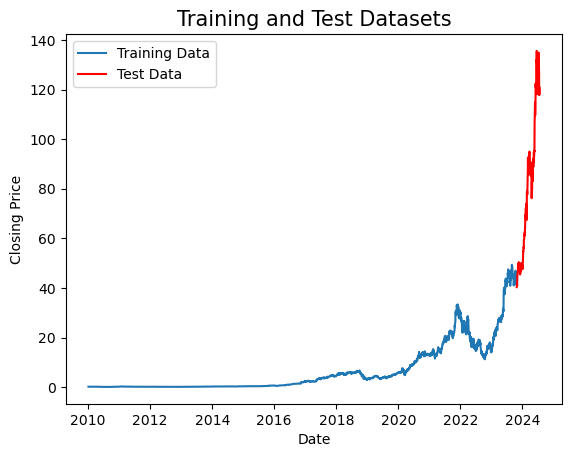

In [22]:
plt.plot(NVDA_train['ds'], NVDA_train['y'], label= 'Training Data')
plt.plot(NVDA_test['ds'], NVDA_test['y'], color='red', label= 'Test Data')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Training and Test Datasets', size = 15)
plt.legend()
plt.show()

## Prophet

In [23]:
# Fitting model to training data

m = Prophet()
m.fit(NVDA_train)
future = NVDA[['ds']]
forecast = m.predict(future)
forecast.tail()

17:57:51 - cmdstanpy - INFO - Chain [1] start processing
17:57:54 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
3655,2024-07-15,39.268070,35.434217,44.463136,38.951166,39.520428,0.647767,0.647767,0.647767,0.016538,0.016538,0.016538,0.631229,0.631229,0.631229,0.0,0.0,0.0,39.915837
3656,2024-07-16,39.288360,35.315136,44.528604,38.968306,39.545028,0.631584,0.631584,0.631584,-0.023637,-0.023637,-0.023637,0.655221,0.655221,0.655221,0.0,0.0,0.0,39.919944
3657,2024-07-17,39.308650,35.315342,44.876487,38.986460,39.568224,0.657183,0.657183,0.657183,-0.019184,-0.019184,-0.019184,0.676368,0.676368,0.676368,0.0,0.0,0.0,39.965833
3658,2024-07-18,39.328940,35.501333,44.398598,39.004867,39.590313,0.687984,0.687984,0.687984,-0.006333,-0.006333,-0.006333,0.694316,0.694316,0.694316,0.0,0.0,0.0,40.016923
3659,2024-07-19,39.349229,35.552882,44.653557,39.023458,39.610800,0.671624,0.671624,0.671624,-0.037169,-0.037169,-0.037169,0.708793,0.708793,0.708793,0.0,0.0,0.0,40.020853


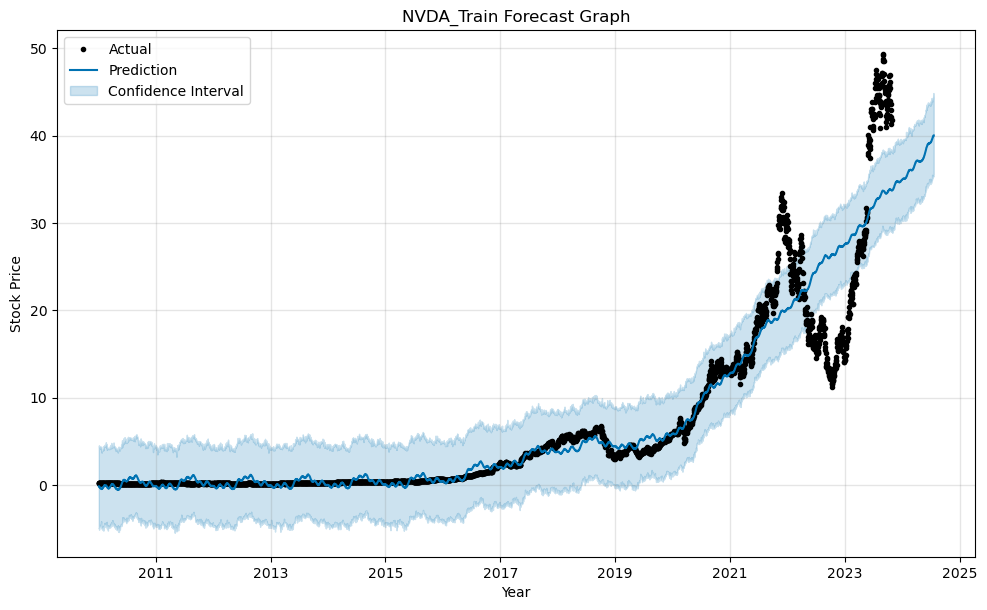

In [24]:
# Prophet Forecast

m.plot(forecast)
plt.title('NVDA_Train Forecast Graph')
plt.legend(['Actual', 'Prediction', 'Confidence Interval'], loc='upper left')
plt.ylabel('Stock Price')
plt.xlabel('Year')
plt.show()

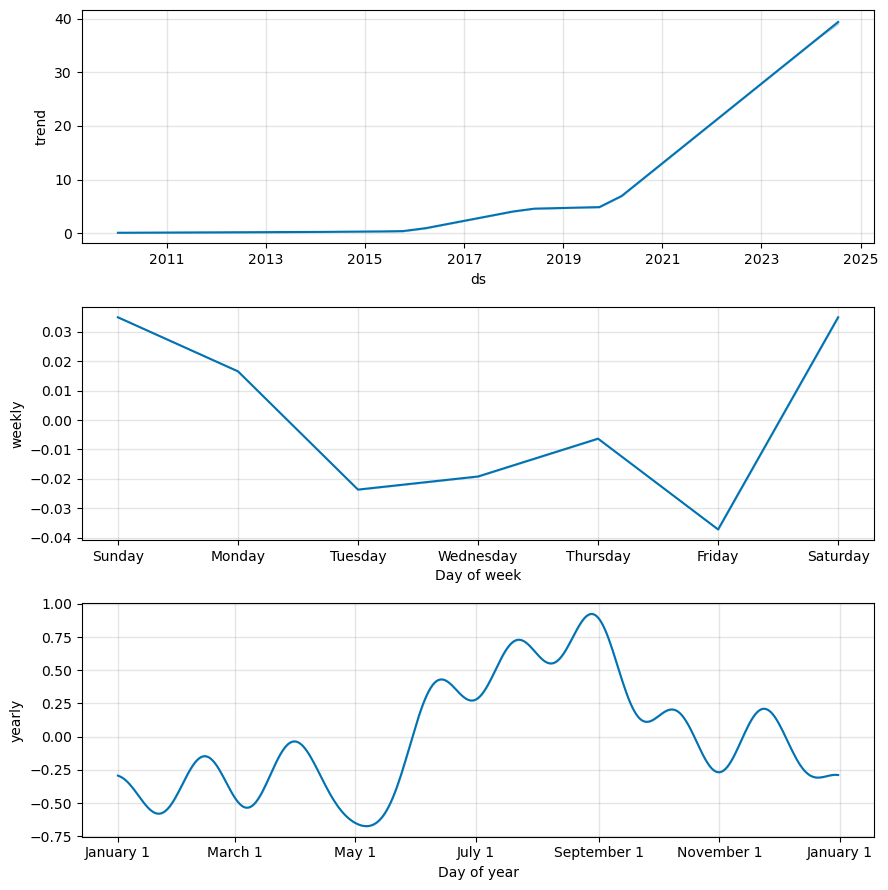

In [25]:
m.plot_components(forecast);

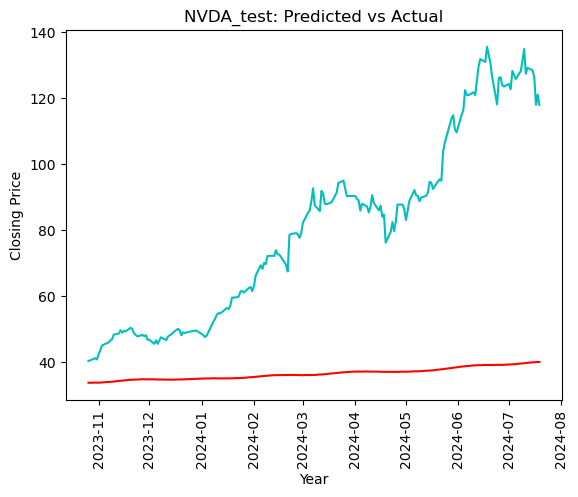

In [26]:
# Comparing Prophet forecast with actual test data

plt.plot(forecast.iloc[-len(NVDA_test):]['ds'], forecast.iloc[-len(NVDA_test):]['yhat'], 'r')
plt.plot(NVDA_test['ds'], NVDA_test['y'], 'c')
plt.xlabel("Year")
plt.xticks(rotation=90)
plt.ylabel("Closing Price")
plt.title("NVDA_test: Predicted vs Actual")
plt.show()

In [27]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

y_prediction = forecast.iloc[-len(NVDA_test):]['yhat']
y_actual = NVDA_test['y']

print(f"MAE: {round(mean_absolute_error(y_actual, y_prediction),5)}")
print(f"MAPE: {round(mean_absolute_percentage_error(y_actual, y_prediction),5)}")
print(f"R-Squared: {round(r2_score(y_actual, y_prediction),5)}")

MAE: 43.73412
MAPE: 0.49264
R-Squared: -2.3561


As you can see, whether looking at graphs or error metrics, the forecast result is not very good since it's exhibiting a very large error. It's very likely because of a sudden, dramatic spike in NVDA price in the test data, which cannot be anticipated by the train data, resulting in a more pessimistic forecast. Based on that assumption, let's try to fit the entire dataset without splitting it first and then forecast the NVDA price one year into the future.

In [28]:
# Fitting the model into the entire dataset

m1 = Prophet()
m1.fit(NVDA)
future1 = m1.make_future_dataframe(periods=365, freq='B')
forecast1 = m1.predict(future1)
forecast1.tail()

17:57:58 - cmdstanpy - INFO - Chain [1] start processing
17:57:59 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
4020,2025-12-08,104.693285,92.081953,114.587723,102.663442,106.556622,-1.118028,-1.118028,-1.118028,0.063516,0.063516,0.063516,-1.181543,-1.181543,-1.181543,0.0,0.0,0.0,103.575257
4021,2025-12-09,104.754544,92.500097,114.396404,102.715850,106.633669,-1.248063,-1.248063,-1.248063,-0.035071,-0.035071,-0.035071,-1.212992,-1.212992,-1.212992,0.0,0.0,0.0,103.506481
4022,2025-12-10,104.815804,91.606741,115.099944,102.767231,106.710715,-1.376312,-1.376312,-1.376312,-0.133388,-0.133388,-0.133388,-1.242924,-1.242924,-1.242924,0.0,0.0,0.0,103.439492
4023,2025-12-11,104.877063,92.161917,114.375621,102.816283,106.787762,-1.352005,-1.352005,-1.352005,-0.080938,-0.080938,-0.080938,-1.271067,-1.271067,-1.271067,0.0,0.0,0.0,103.525058
4024,2025-12-12,104.938322,92.616862,114.721704,102.852393,106.864809,-1.359527,-1.359527,-1.359527,-0.062360,-0.062360,-0.062360,-1.297167,-1.297167,-1.297167,0.0,0.0,0.0,103.578795


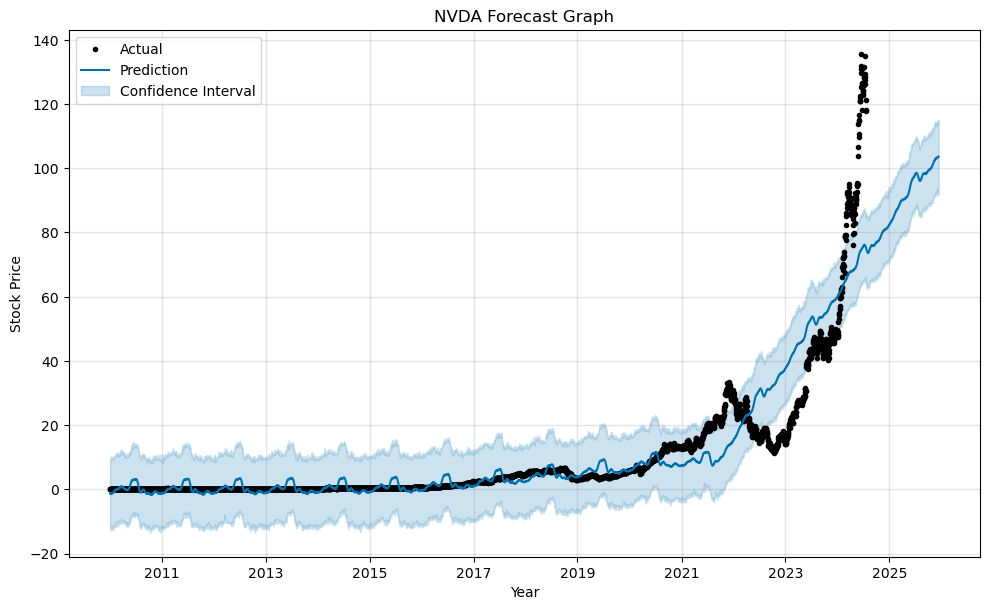

In [29]:
# Prophet forecast

m1.plot(forecast1)
plt.title('NVDA Forecast Graph')
plt.legend(['Actual', 'Prediction', 'Confidence Interval'], loc='upper left')
plt.ylabel('Stock Price')
plt.xlabel('Year')
plt.show()

In [30]:
y_prediction1 = forecast1.iloc[-len(NVDA):]['yhat']
y_actual1 = NVDA['y']

print(f"MAE: {round(mean_absolute_error(y_actual1, y_prediction1),5)}")
print(f"MAPE: {round(mean_absolute_percentage_error(y_actual1, y_prediction1),5)}")
print(f"R-Squared: {round(r2_score(y_actual1, y_prediction1),5)}")

MAE: 9.6357
MAPE: 3.18158
R-Squared: 0.17225


Despite not splitting the data, the forecast result is still not very good, especially when we get to the test data part. The price rise is so dramatic that it still cannot be anticipated.

Now we know the Prophet can't give us a very good forecast, let's move into other models. We will use linear regression, random forest regressor, and XGBoost regressor as starter.

# Other Models Comparison

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor

In [32]:
NVDA1=dfstock[dfstock['Symbol']=='NVDA']
NVDA1.set_index('Date', inplace=True)
NVDA1.drop(columns=['Symbol', 'Close'], axis=1, inplace=True) # Dropping close variable since we're going to use Adj close
NVDA1

,Adj Close,High,Low,Open,Volume
Date,,,,,
2010-01-04,0.195251,0.465500,0.452750,0.462750,800204000.0
2010-01-05,0.198102,0.474000,0.460500,0.460500,728648000.0
2010-01-06,0.199369,0.473000,0.464250,0.468750,649168000.0
2010-01-07,0.195462,0.471500,0.459250,0.469500,547792000.0
2010-01-08,0.195885,0.467000,0.456250,0.459000,478168000.0
...,...,...,...,...,...
2024-07-15,128.440002,131.389999,127.180000,130.559998,208326200.0
2024-07-16,126.360001,129.039993,124.580002,128.440002,214769500.0
2024-07-17,117.989998,121.849998,116.720001,121.349998,390086200.0


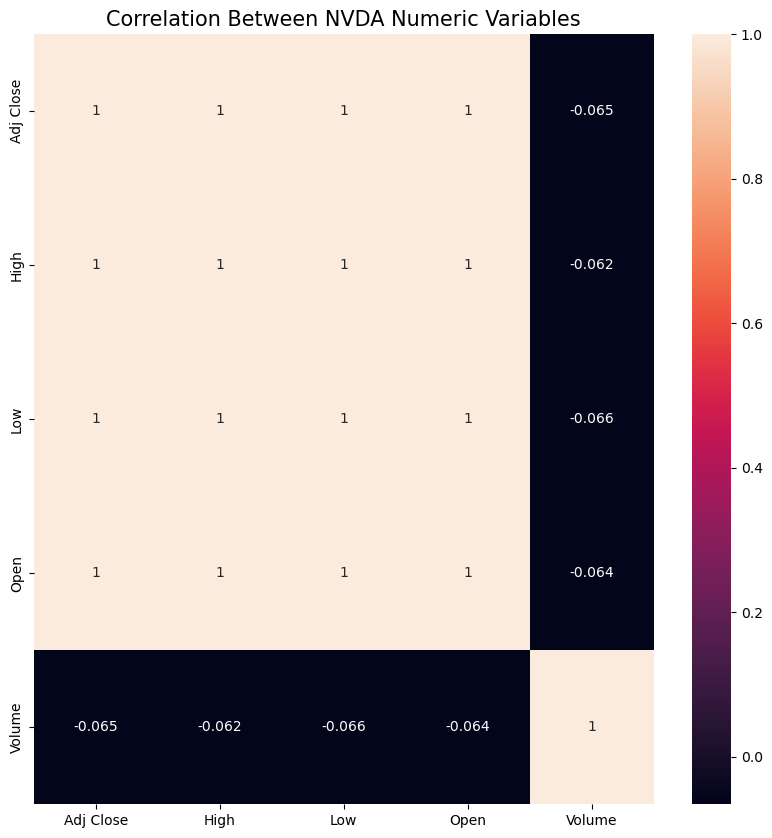

In [33]:
# Correlation between numeric variables

plt.figure(figsize=(10,10))
sns.heatmap(NVDA1.corr('pearson'),annot=True)
plt.title('Correlation Between NVDA Numeric Variables', size = 15)
plt.show()

Judging from this correlation matrix, it's obvious most of the variables are correlated except Volume. When you build a model with these independent variables, it's surely going to be overfit. But if we drop every variable except Volume, then we are obviously going to get a poor model. For now, let's go ahead with the variables for the sake of it.

In [34]:
# Separating between X and Y variables

X = NVDA1.drop(['Adj Close'], axis=1)
y = NVDA1['Adj Close']

In [35]:
# Splitting data

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,  
                                                    test_size = 0.05,
                                                    shuffle=False)

In [36]:
# Models

lr = LinearRegression()
rf = RandomForestRegressor(random_state=1)
xgb = XGBRegressor(random_state=1)

## Linear Regression

In [37]:
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print(f"MAE: {round(mean_absolute_error(y_pred_lr, y_test),5)}")
print(f"MAPE: {round(mean_absolute_percentage_error(y_pred_lr, y_test),5)}")
print(f"R-Squared: {round(r2_score(y_pred_lr, y_test),5)}")

MAE: 0.68065
MAPE: 0.00786
R-Squared: 0.99883


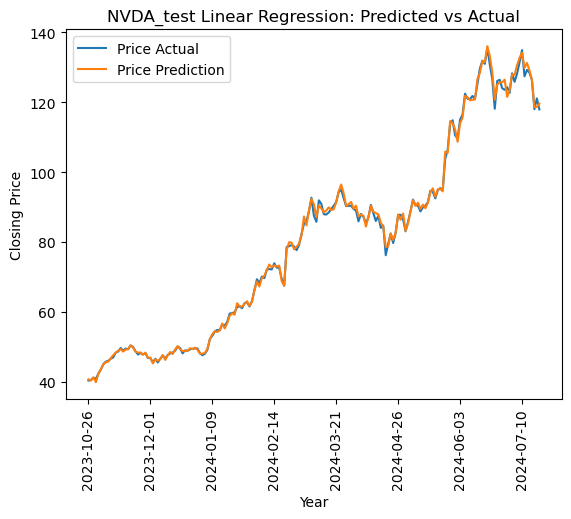

In [38]:
lr_df = pd.DataFrame({'Date':X_test.index, 'Price Actual': y_test.values, 'Price Prediction': y_pred_lr})
lr_df.plot(x='Date', y=['Price Actual','Price Prediction'])
plt.xlabel("Year")
plt.xticks(rotation=90)
plt.ylabel("Closing Price")
plt.title("NVDA_test Linear Regression: Predicted vs Actual")
plt.show()

To the surprise of absolutely no one, the model shows a clear sign of being overfit. The graph looks nice and all, but it is definitely overfit with an unnaturally high R-squared number. While the numbers look nice, we won't use this model.

## Random Forest

In [39]:
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print(f"MAE: {round(mean_absolute_error(y_pred_rf, y_test),5)}")
print(f"MAPE: {round(mean_absolute_percentage_error(y_pred_rf, y_test),5)}")
print(f"R-Squared: {round(r2_score(y_pred_rf, y_test),5)}")

MAE: 32.03715
MAPE: 0.65845
R-Squared: -815.02981


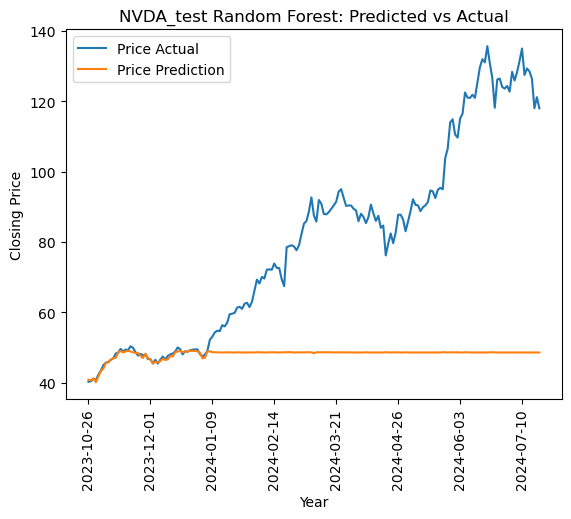

In [40]:
rf_df = pd.DataFrame({'Date':X_test.index, 'Price Actual': y_test.values, 'Price Prediction': y_pred_rf})
rf_df.plot(x='Date', y=['Price Actual','Price Prediction'])
plt.xlabel("Year")
plt.xticks(rotation=90)
plt.ylabel("Closing Price")
plt.title("NVDA_test Random Forest: Predicted vs Actual")
plt.show()

## XGBoost

In [41]:
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print(f"MAE: {round(mean_absolute_error(y_pred_xgb, y_test),5)}")
print(f"MAPE: {round(mean_absolute_percentage_error(y_pred_xgb, y_test),5)}")
print(f"R-Squared: {round(r2_score(y_pred_xgb, y_test),5)}")

MAE: 32.7195
MAPE: 0.68153
R-Squared: -985.27459


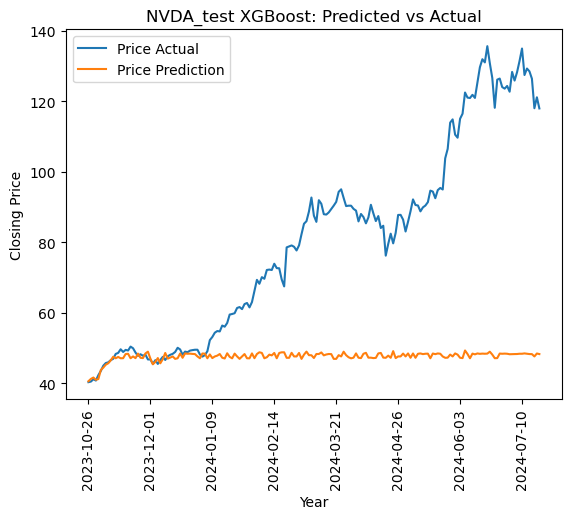

In [42]:
xgb_df = pd.DataFrame({'Date':X_test.index, 'Price Actual': y_test.values, 'Price Prediction': y_pred_xgb})
xgb_df.plot(x='Date', y=['Price Actual','Price Prediction'])
plt.xlabel("Year")
plt.xticks(rotation=90)
plt.ylabel("Closing Price")
plt.title("NVDA_test XGBoost: Predicted vs Actual")
plt.show()

Random Forest and XGBoost model shows some signs of being overfit too before giving a flat prediction onwards. This is apparently is a weakness of every tree-based alogarithm, because they are unable to extrapolate values beyond the limits of the training data.

For more information, you can read:
1. https://neptune.ai/blog/random-forest-regression-when-does-it-fail-and-why
2. https://towardsdatascience.com/why-xgboost-cant-solve-all-your-problems-b5003a62d12a

## ARIMA

Because the other models failed, let's get back to the good old ARIMA to forecast the NVDA price.

An ARIMA model has three component functions: AR (p), the number of lag observations or autoregressive terms in the model; I (d), the difference in the nonseasonal observations; and MA (q), the size of the moving average window. An ARIMA model order is depicted as (p,d,q) with values for the order or number of times the function occurs in running the model. Values of zero are acceptable. (https://www.mastersindatascience.org/learning/statistics-data-science/what-is-arima-modeling/)

In [43]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [44]:
# Splitting data

X_train_NVDA = NVDA[:3477]
X_valid_NVDA = NVDA[3477:]

print("X_train Shape", X_train_NVDA.shape)
print("X_valid Shape", X_valid_NVDA.shape)

X_train Shape (3477, 2)
X_valid Shape (183, 2)


In [45]:
NVDA_year_train = X_train_NVDA[['ds', 'y']]
NVDA_year_valid = X_valid_NVDA[['ds', 'y']]

NVDA_year_train.set_index('ds', inplace=True)
NVDA_year_valid.set_index('ds', inplace=True)

In [46]:
# Check stationary

def check_stationarity(data):
    NVDA_year_train = adfuller(data, autolag='AIC')
    adf = NVDA_year_train[0]
    pvalue = NVDA_year_train[1]
    critical_value = NVDA_year_train[4]['5%']
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations', 'Critical Value']
    for value,label in zip(NVDA_year_train, labels):
        print(label+' : '+str(value) )

    if (pvalue < 0.05):
        print("Strong Evidence Against The Null Hypothesis(Ho), Reject The Null Hypothesis. Data Is Stationary")
    else:
        print("Weak Evidence Against Null Hypothesis, Indicating It Is Non-Stationary ")

check_stationarity(NVDA_year_train)

ADF Test Statistic : 1.0816526328565954
p-value : 0.9950569530101857
#Lags Used : 30
Number of Observations : 3446
Critical Value : {'1%': -3.432249064957662, '5%': -2.8623790980971378, '10%': -2.567216667193267}
Weak Evidence Against Null Hypothesis, Indicating It Is Non-Stationary 


In [47]:
data_diff = NVDA_year_train.diff()
data_diff.dropna(inplace=True)
check_stationarity(data_diff)

ADF Test Statistic : -8.783684713982243
p-value : 2.3395406005789255e-14
#Lags Used : 30
Number of Observations : 3445
Critical Value : {'1%': -3.432249616621761, '5%': -2.8623793417710734, '10%': -2.5672167969186113}
Strong Evidence Against The Null Hypothesis(Ho), Reject The Null Hypothesis. Data Is Stationary


The data looks stationary on first differencing.

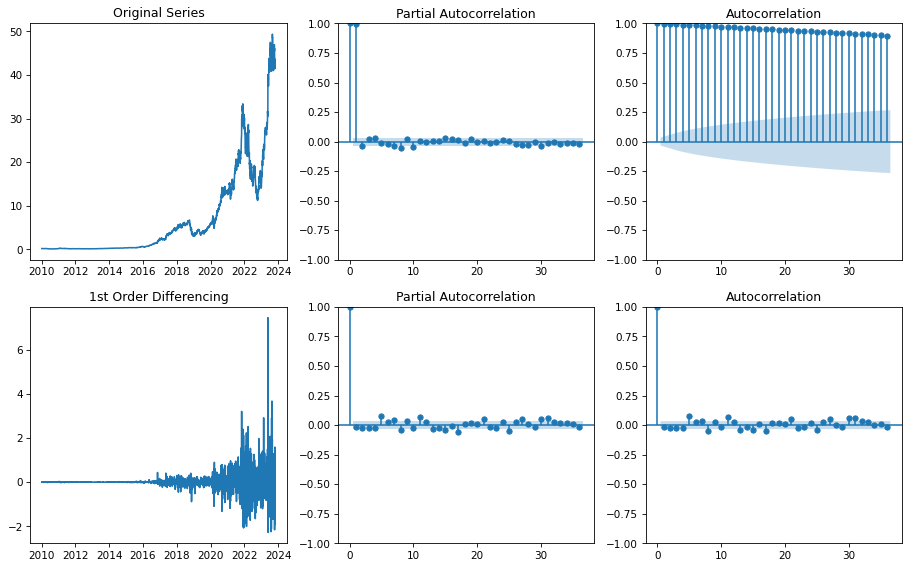

In [48]:
plt.rcParams.update({'figure.figsize':(15,9), 'figure.dpi':75})

# Original Series
fig, axes = plt.subplots(2, 3)
axes[0, 0].plot(NVDA_year_train); axes[0, 0].set_title('Original Series')
plot_pacf(NVDA_year_train, ax=axes[0, 1])
plot_acf(NVDA_year_train, ax=axes[0, 2])

# 1st Differencing
axes[1, 0].plot(NVDA_year_train.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_pacf(NVDA_year_train.diff().dropna(), ax=axes[1, 1])
plot_acf(NVDA_year_train.diff().dropna(), ax=axes[1, 2])

plt.show()

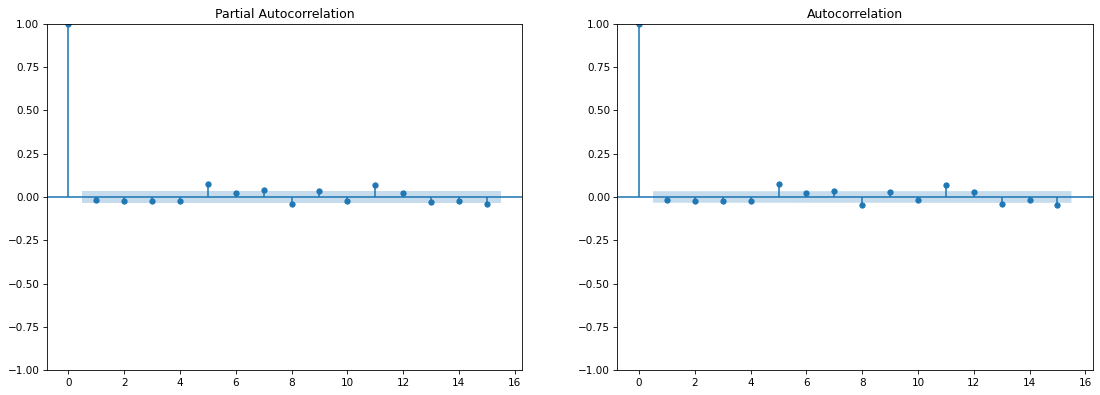

In [49]:
plt.rcParams.update({'figure.figsize':(18,6), 'figure.dpi':75})
fig, ax = plt.subplots(1, 2)
plot_pacf(NVDA_year_train.diff().dropna(), lags = 15, ax=ax[0])
plot_acf(NVDA_year_train.diff().dropna(), lags = 15, ax=ax[1])
plt.show()

We will use pmdarima search to find the most optimal ARIMA model. 

The auto-ARIMA process seeks to identify the most optimal parameters for an ARIMA model, settling on a single fitted ARIMA model. This process is based on the commonly-used R function. The auto_arima function fits the best ARIMA model to a univariate time series according to a provided information criterion (either AIC, AICc, BIC or HQIC). The function performs a search (either stepwise or parallelized) over possible model & seasonal orders within the constraints provided, and selects the parameters that minimize the given metric.

In [50]:
# ARIMA grid search

import pmdarima as pm

model_arima = pm.auto_arima(NVDA_year_train, start_p=0, start_q=0, start_order=0, max_p=10 ,max_q=10, max_order=10, 
                      test='adf', stepwise=False, trace=True, seasonal=False) 

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3186.914, Time=0.73 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3187.846, Time=0.61 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3187.283, Time=1.11 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3188.167, Time=1.30 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=3189.067, Time=1.77 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=3167.615, Time=4.10 sec
 ARIMA(0,1,6)(0,0,0)[0] intercept   : AIC=3169.193, Time=2.50 sec
 ARIMA(0,1,7)(0,0,0)[0] intercept   : AIC=3166.362, Time=3.22 sec
 ARIMA(0,1,8)(0,0,0)[0] intercept   : AIC=3164.970, Time=4.09 sec
 ARIMA(0,1,9)(0,0,0)[0] intercept   : AIC=3163.465, Time=4.62 sec
 ARIMA(0,1,10)(0,0,0)[0] intercept   : AIC=3165.416, Time=4.66 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3187.902, Time=1.18 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3188.100, Time=2.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3180.526, Time=3.42 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3190.070, Time=5.51 sec
 ARIMA(1,

In [51]:
model_arima

ARIMA(order=(4, 1, 4), scoring_args={}, suppress_warnings=True)

In [52]:
model_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3477
Model:               SARIMAX(4, 1, 4)   Log Likelihood               -1561.033
Date:                Sun, 21 Jul 2024   AIC                           3142.065
Time:                        18:07:25   BIC                           3203.602
Sample:                             0   HQIC                          3164.034
                               - 3477                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0516      0.028      1.818      0.069      -0.004       0.107
ar.L1         -0.8909      0.078    -11.492      0.000      -1.043      -0.739
ar.L2         -0.4240      0.016    -27.218      0.000      -0.455      -0.393
ar.L3         -1.0928      0.023    -47.246      0.000      -1.138      -1.047
ar.L4         -0.7054      0.072     -9.777      0.000      -0.847      -0.564
ma.L1          0.8936      0.081     11.090      0.000       0.736       1.051
ma.L2          0.4049      0.019     21.218      0.000       0.368       0.442
ma.L3          1.0712      0.023     47.200      0.000       1.027       1.116
ma.L4          0.6719      0.075      8.903      0.000       0.524       0.820
sigma2         0.1447      0.001    184.104      0.000       0.143       0.146
===================================================================================
Ljung-Box (L1) (Q):                   1.45   Jarque-Bera (JB):            410897.35
Prob(Q):                              0.23   Prob(JB):                         0.00
Heteroskedasticity (H):            2353.39   Skew:                             2.67
Prob(H) (two-sided):                  0.00   Kurtosis:                        55.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Now that we know that the ARIMA (4,1,4) model is the best to use for this dataset, let's make the forecast right away.

In [53]:
# ARIMA forecasting

n_forecast=model_arima.predict(n_periods=183)
n_forecast

C:\Users\surja\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


3477    41.655726
3478    41.873723
3479    42.058037
3480    42.130318
3481    41.888104
          ...    
3655    44.129234
3656    44.208069
3657    44.195677
3658    44.123485
3659    44.095466
Length: 183, dtype: float64

In [54]:
df_forecast1=pd.DataFrame(n_forecast, columns=['Forecast'])
df_forecast1=df_forecast1.assign(Actual=NVDA_year_valid.values)
df_forecast1.set_index(NVDA_year_valid.index, inplace=True)
df_forecast1

,Forecast,Actual
ds,,
2023-10-26,41.655726,40.326000
2023-10-27,41.873723,40.500000
2023-10-30,42.058037,41.160999
2023-10-31,42.130318,40.779999
2023-11-01,41.888104,42.325001
...,...,...
2024-07-15,44.129234,128.440002
2024-07-16,44.208069,126.360001
2024-07-17,44.195677,117.989998


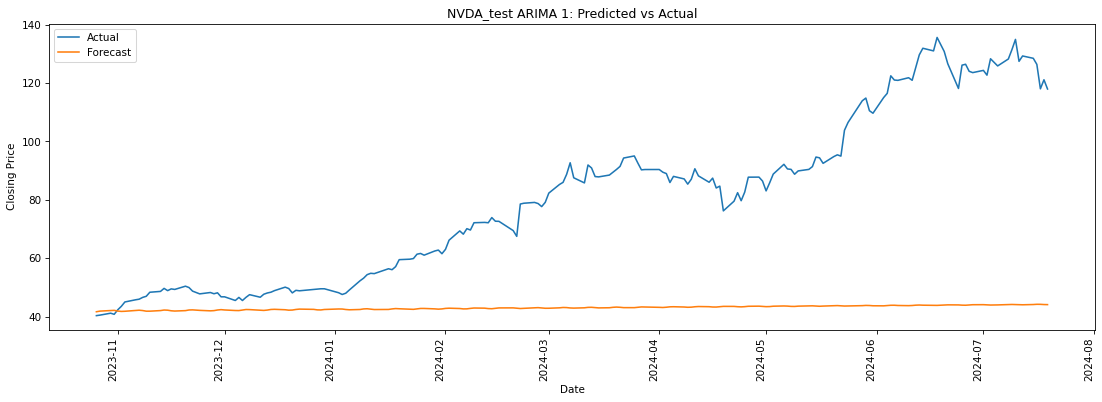

In [55]:
df_forecast1.plot(y=['Actual','Forecast'])
plt.xlabel("Date")
plt.xticks(rotation=90)
plt.ylabel("Closing Price")
plt.title("NVDA_test ARIMA 1: Predicted vs Actual")
plt.show()

In [56]:
print(f"MAE: {round(mean_absolute_error(NVDA_year_valid.values, n_forecast),5)}")
print(f"MAPE: {round(mean_absolute_percentage_error(NVDA_year_valid.values, n_forecast),5)}")
print(f"R-Squared: {round(r2_score(NVDA_year_valid.values, n_forecast),5)}")

MAE: 37.22822
MAPE: 0.39643
R-Squared: -1.74132


The forecast is still not that good, as the previous problems still persist. In this case, using the rolling forecast technique is desirable. A rolling forecast is a type of financial model that predicts the future performance of a business over a continuous period, based on historical data. Unlike static budgets that forecast the future for a fixed time frame, e.g., January to December, a rolling forecast is regularly updated throughout the year to reflect any changes. (https://corporatefinanceinstitute.com/resources/accounting/rolling-forecast/)

In [57]:
# ARIMA rolling forecast

NVDA_arima_train = NVDA_year_train.values
NVDA_arima_test= NVDA_year_valid.values
NVDA_hist=[x for x in NVDA_arima_train]
predictions = list()

for t in range(len(NVDA_arima_test)):
 model = ARIMA(NVDA_hist, order=(4,1,4))
 model_fit = model.fit()
 output = model_fit.forecast()
 yhat = output[0]
 predictions.append(yhat)
 obs = NVDA_arima_test[t]
 NVDA_hist.append(obs)
 print('Predicted=%f, Actual=%f' % (yhat, obs))

# Reference https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=41.659203, Actual=40.326000


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=40.505123, Actual=40.500000


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=40.690627, Actual=41.160999


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=41.208006, Actual=40.779999


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=40.566784, Actual=42.325001


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=42.133397, Actual=43.506001


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=43.523932, Actual=45.005001


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=45.195644, Actual=45.750999


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=45.745596, Actual=45.955002


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=45.839944, Actual=46.574001


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=46.381728, Actual=46.950001


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=47.024636, Actual=48.334999


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=48.464460, Actual=48.619999


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=48.720003, Actual=49.655998


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=49.541806, Actual=48.888000


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=48.723663, Actual=49.480000


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=49.473020, Actual=49.298000


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=49.335882, Actual=50.409000


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=50.554332, Actual=49.944000


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=49.783624, Actual=48.716000


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=48.732307, Actual=47.776001


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=47.565206, Actual=48.242001


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=48.407405, Actual=47.820999


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=47.884309, Actual=48.139999


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=48.206170, Actual=46.770000


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=46.666029, Actual=46.764999


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=46.652609, Actual=45.509998


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=45.628722, Actual=46.566002


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=46.730443, Actual=45.502998


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=45.570103, Actual=46.596001


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=46.467975, Actual=47.506001


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=47.373731, Actual=46.626999


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=46.536119, Actual=47.657001


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=47.620600, Actual=48.088001


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=48.284228, Actual=48.349998


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=48.278975, Actual=48.889999


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=48.790480, Actual=50.077000


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=49.994007, Actual=49.604000


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=49.699449, Actual=48.111000


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=48.303313, Actual=48.990002


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=49.006958, Actual=48.830002


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=48.837246, Actual=49.278999


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=49.094556, Actual=49.417000


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=49.322142, Actual=49.521999


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=49.661814, Actual=49.521999


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=49.541823, Actual=48.167999


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=48.191211, Actual=47.569000


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=47.433582, Actual=47.998001


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=48.044766, Actual=49.097000


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=49.149403, Actual=52.252998


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=52.312341, Actual=53.139999


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=53.087678, Actual=54.349998


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=54.225618, Actual=54.821999


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=54.708529, Actual=54.709999


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=54.878310, Actual=56.382000


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=56.440051, Actual=56.053001


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=56.096197, Actual=57.106998


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=56.935324, Actual=59.491001


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=59.484006, Actual=59.653999


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=59.734297, Actual=59.873001


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=59.943308, Actual=61.362000


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=61.519359, Actual=61.617001


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=61.726556, Actual=61.030998


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=61.079235, Actual=62.465000


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=62.591424, Actual=62.773998


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=62.947969, Actual=61.527000


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=61.684003, Actual=63.027000


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=63.116111, Actual=66.160004


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=66.214675, Actual=69.332001


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=69.469443, Actual=68.223000


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=68.330595, Actual=70.098999


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=70.390460, Actual=69.640999


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=69.906370, Actual=72.133003


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=72.397418, Actual=72.248001


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=72.410271, Actual=72.127998


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=72.431776, Actual=73.900002


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=74.085668, Actual=72.657997


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=72.951131, Actual=72.612999


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=72.824866, Actual=69.452003


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=69.671366, Actual=67.472000


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=67.642776, Actual=78.538002


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=78.524033, Actual=78.817001


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=79.003573, Actual=79.092003


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=79.202460, Actual=78.700996


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=78.729004, Actual=77.663002


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=77.721986, Actual=79.112000


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=79.008252, Actual=82.278999


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=83.125474, Actual=85.237000


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=85.363299, Actual=85.963997


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=85.536731, Actual=88.699997


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=88.717358, Actual=92.668999


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=93.572139, Actual=87.528000


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=87.785483, Actual=85.774002


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=86.086127, Actual=91.913002


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=92.031692, Actual=90.888000


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=90.495362, Actual=87.944000


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=88.213890, Actual=87.836998


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=87.677886, Actual=88.455002


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=88.545179, Actual=89.398003


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=89.016737, Actual=90.372002


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=90.440994, Actual=91.434998


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=91.139125, Actual=94.289001


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=94.239508, Actual=95.001999


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=94.835767, Actual=92.560997


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=92.789487, Actual=90.250000


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=90.733079, Actual=90.356003


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=90.934574, Actual=90.362999


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=90.717131, Actual=89.452003


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=89.917900, Actual=88.963997


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=89.381943, Actual=85.904999


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=86.170702, Actual=88.008003


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=88.498461, Actual=87.133003


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=86.315330, Actual=85.353996


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=85.219431, Actual=87.039001


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=86.563380, Actual=90.615997


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=90.518801, Actual=88.185997


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=87.869392, Actual=86.000999


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=86.399810, Actual=87.415001


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=87.484652, Actual=84.035004


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=83.985336, Actual=84.670998


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=85.044992, Actual=76.199997


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=76.284146, Actual=79.517998


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=79.863327, Actual=82.422997


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=81.735229, Actual=79.677002
Predicted=79.731666, Actual=82.632004


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=81.857332, Actual=87.735001


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=88.157358, Actual=87.757004


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=87.339373, Actual=86.402000


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=86.735276, Actual=83.041000


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=83.377338, Actual=85.817001


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=87.123092, Actual=88.789001


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=88.449479, Actual=92.139999


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=92.152978, Actual=90.554001


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=90.167104, Actual=90.412003


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=90.862879, Actual=88.747002


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=88.831181, Actual=89.877998


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=90.426304, Actual=90.399002


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=90.289455, Actual=91.356003


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=91.498467, Actual=94.629997


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=94.477004, Actual=94.359001


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=94.174294, Actual=92.478996


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=92.704619, Actual=94.779999


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=95.119821, Actual=95.386002


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=95.339232, Actual=94.949997


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=95.162393, Actual=103.799004


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=104.180711, Actual=106.469002


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=106.521000, Actual=113.901001


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=113.599597, Actual=114.824997


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=114.722779, Actual=110.500000


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=110.515342, Actual=109.633003


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=110.378078, Actual=115.000000


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=116.857881, Actual=116.436996


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=117.822793, Actual=122.440002


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=122.992972, Actual=120.998001


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=120.281340, Actual=120.888000


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=120.179208, Actual=121.790001


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=122.044778, Actual=120.910004


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=122.186314, Actual=125.199997


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=127.064620, Actual=129.610001


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=131.449916, Actual=131.880005


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=132.458465, Actual=130.979996


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=130.586934, Actual=135.580002


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=135.344608, Actual=130.779999


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=130.678857, Actual=126.570000


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=127.685162, Actual=118.110001


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=119.274388, Actual=126.089996


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=128.900287, Actual=126.400002


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=127.344426, Actual=123.989998


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=122.970187, Actual=123.540001


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=121.410230, Actual=124.300003


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=123.177441, Actual=122.669998


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=122.462361, Actual=128.279999


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=129.454135, Actual=125.830002


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=127.798722, Actual=128.199997


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=128.906176, Actual=131.380005


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=131.039226, Actual=134.910004


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=134.129109, Actual=127.400002


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=126.126537, Actual=129.240005


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=128.368440, Actual=128.440002


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=130.052429, Actual=126.360001


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=127.546443, Actual=117.989998


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=119.267543, Actual=121.089996


C:\Users\surja\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predicted=121.707139, Actual=117.930000


In [58]:
df_arima=pd.DataFrame(NVDA_arima_test, columns=['Actual'])
df_arima=df_arima.assign(Predicted=predictions)
df_arima.set_index(NVDA_year_valid.index, inplace=True)
df_arima

,Actual,Predicted
ds,,
2023-10-26,40.326000,41.659203
2023-10-27,40.500000,40.505123
2023-10-30,41.160999,40.690627
2023-10-31,40.779999,41.208006
2023-11-01,42.325001,40.566784
...,...,...
2024-07-15,128.440002,128.368440
2024-07-16,126.360001,130.052429
2024-07-17,117.989998,127.546443


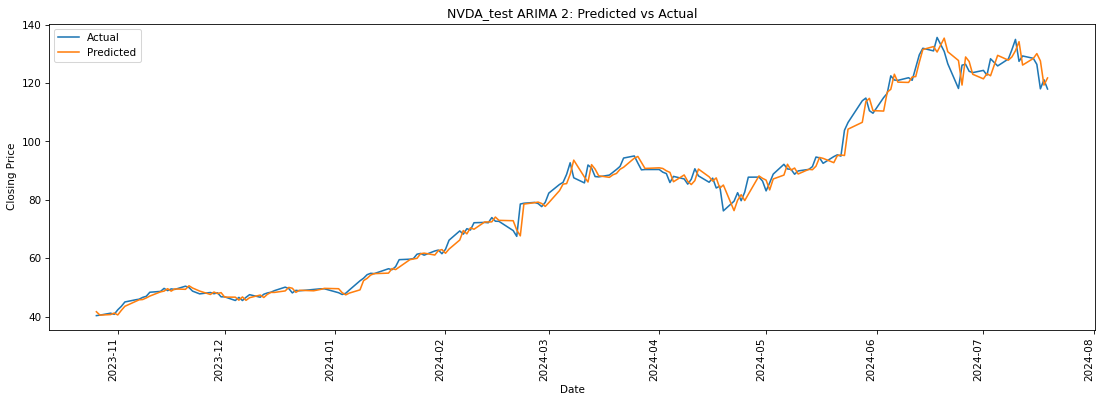

In [59]:
df_arima.plot(y=['Actual','Predicted'])
plt.xlabel("Date")
plt.xticks(rotation=90)
plt.ylabel("Closing Price")
plt.title("NVDA_test ARIMA 2: Predicted vs Actual")
plt.show()

In [60]:
print(f"MAE: {round(mean_absolute_error(NVDA_arima_test, predictions),5)}")
print(f"MAPE: {round(mean_absolute_percentage_error(NVDA_arima_test, predictions),5)}")
print(f"R-Squared: {round(r2_score(NVDA_arima_test, predictions),5)}")

MAE: 1.88212
MAPE: 0.02229
R-Squared: 0.99042


As we can see, ARIMA rolling forecast performs considerably better than other models. But still, the forecast result looks like it's lagging one day behind the actual price. Unless there is a dramatic change in price in one day, then the model will be good enough to use. 

In [61]:
df_error=pd.DataFrame(columns=['Model','MAE','MAPE','R-Squared'])
error={'Model':['Prophet','Linear','Random Forest','XGBoost','ARIMA Rolling'],
       'MAE':[round(mean_absolute_error(y_actual, y_prediction),5),
             round(mean_absolute_error(y_pred_lr, y_test),5),
             round(mean_absolute_error(y_pred_rf, y_test),5),
             round(mean_absolute_error(y_pred_xgb, y_test),5), 
             round(mean_absolute_error(NVDA_arima_test, predictions),5)], 
       'MAPE':[round(mean_absolute_percentage_error(y_actual, y_prediction),5), 
              round(mean_absolute_percentage_error(y_pred_lr, y_test),5), 
              round(mean_absolute_percentage_error(y_pred_rf, y_test),5), 
              round(mean_absolute_percentage_error(y_pred_xgb, y_test),5),
              round(mean_absolute_percentage_error(NVDA_arima_test, predictions),5)],
       'R-Squared':[round(r2_score(y_actual, y_prediction),5),
                   round(r2_score(y_pred_lr, y_test),5),
                   round(r2_score(y_pred_rf, y_test),5),
                   round(r2_score(y_pred_xgb, y_test),5),
                   round(r2_score(NVDA_arima_test, predictions),5)]}
df_error=pd.DataFrame(error)
df_error

,Model,MAE,MAPE,R-Squared
0,Prophet,43.73412,0.49264,-2.35610
1,Linear,0.68065,0.00786,0.99883
2,Random Forest,32.03715,0.65845,-815.02981
3,XGBoost,32.71950,0.68153,-985.27459
4,ARIMA Rolling,1.88212,0.02229,0.99042


# Afterword

Sudden dramatic increase of the NVDA price mostly failed to be anticipated properly by most of the models, especially since the train data only cover up until 2023-10-25, and the dramatic rise of the price still happened after that. So far, only ARIMA, combined with rolling forecast technique can give a better forecast value.


With the data trend like this, some new ideas for the treatment would be:
1. Only using the data from 2023 onwards, since data from previous date looks irrelevant
2. Wait for more data to generate
3. Add new variables for regression predictor (examples like lags, moving average, and others)